# Analysis of customer churn at Metanprom Bank

# Introduction

**Task** - Analyze the customers of a regional bank and identify customer segments, who tend to leave the bank.

**Data:**

*`bank_scrooge.csv``*.

Dataset contains data on Metanprom bank customers. The bank is located in
Yaroslavl and regional cities: Rostov Veliky and Rybinsk.

Columns:

* `USERID` - user identifier,

* `score` - credit scoring points,

* `city` - city,

* `gender` - gender,

* `age` - age,

* `equity` - property score

* `balance` - account balance,

* `products` - number of products used by the customer,

* `credit_card` - whether there is a credit card,

* `last_activity` - active customer,

* `EST_SALARY` - estimated income of the customer,

* `Churn` - sign of churn.

# Table of Contents 

* [1. Data loading and description](#num1)
    * [1.1. Loading data](#num11)
    * [1.2 Definition of data types, variable types, and the relationship between variables](#num12)
    * [1.3. Checking for inconsistent or incomplete data](#num13)
    * [1.4. Intermediate Inference](#num14)
* [2. Data preparation](#num2)
    * [2.1. Analyzing the nature of omissions](#num21)
    * [2.2. Pre-processing](#num22)
    * [2.3. Coding](#num23)
    * [2.4. Intermediate output](#num24)    
* [3. Exploratory Data Analysis (EDA)](#num3)
    * [3.1. Identification of significant outflow features](#num31)
    * [3.2. Correlation Analysis](#num32)
    * [3.3. Analyzing customer portraits](#num33)
    * [3.4. Intermediate Inference](#num34) 
* [4. Statistical Hypothesis Testing](#num4)
    * [4.1. Test selection and assumption](#num41)
    * [4.2. Formulation of hypotheses](#num42)
    * [4.3. Determining the level of significance, calculating test statistics and P-Value, accepting hypotheses and interpreting the results](#num43)
    * [4.4. Intermediate Inference](#num44) 
* [5. Clustering](#num5)
    * [5.1. Choosing a clustering method, determining the optimal number of clusters](#num51)
    * [5.2. Clustering](#num52)
    * [5.3. Model Validation](#num53)
    * [5.4. Segment prioritization and interpretation of results](#num54)
* [6. General Conclusions](#num6)

<a id="num1"></a>
## 1. Loading and describing data

In [1]:
# Import the necessary libraries

import pandas as pd
import numpy as np
from scipy.stats import mode
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import phik
from phik import resources, report

from scipy.stats import chi2_contingency, ttest_ind

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split
from math import sqrt

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score 

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
# The separator is a comma and the resulting dataframe is stored in the variable 'data'
data = pd.read_csv('my_dataframe.csv', sep=',')

df = data.drop(['Unnamed: 0'], axis=1)

# Displaying the first five rows of the dataframe 'data'
df.head(5)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


<a id="num12"></a>
### 1.2 Definition of data types, variable types, and the relationship between variables

In [3]:
# Checking the data types of each column in the dataframe 'data'
df.dtypes

USERID             int64
score            float64
city              object
gender            object
age              float64
equity             int64
balance          float64
products           int64
credit_card        int64
last_activity      int64
EST_SALARY       float64
churn              int64
dtype: object

* __``USERID``__, __``equity``__, __``products``__, __``credit_card``__, __``last_activity``__ and  __``churn``__ are of type int64. This indicates that these columns contain integer values.

* __``credit_card``__, __``last_activity``__, __``churn``__ are categorical variables that have been encoded as integers.

*  __``score``__, __``age``__, __``balance``__, __``EST_SALARY``__ are of type float64, which means that these columns contain numerical data and include decimal places.

* __``city``__, __``gender``__ are of type object, which means they contain textual or mixed numerical and non-numerical values.

To identify relationships between variables, the corr() method is used to return a correlation matrix.

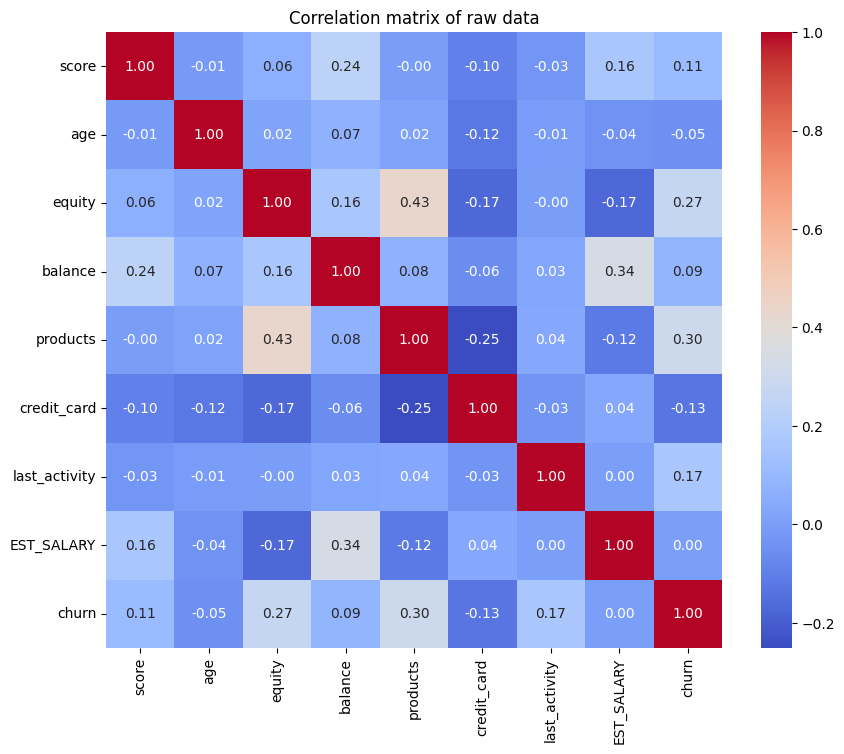

In [4]:
# Remove the USERID column and other non-numerical columns 
data_without_userid = df.drop(['USERID', 'city', 'gender'], axis=1)

# Calculate correlations
corr = data_without_userid.corr().round(3)

# Plotting correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.2f')

plt.title('Correlation matrix of raw data')
plt.show()

Looking at the correlation matrix of the **unprocessed data**, the following conclusions can be drawn:

* The __`score`__ column has the highest correlation (0.24) with __`balance`__ and slightly lower with __`EST_SALARY`__ and __`churn`__ . This suggests that users with high credit scores are likely to have higher account balances, higher expected salaries, and are slightly more likely to churn or leave.

* The __`age`__ column has a small negative correlation with the __`credit_card`__ column, suggesting that older customers are less likely to have a credit card.

* The __`equity`__ column has a fairly high positive correlation with the __`products`__ column, indicating that the more products a customer uses, the higher their ownership score.

* The __`balance`__ column has a higher correlation with __`score`__ and __`EST_SALARY`__, indicating that customers with larger balances have higher credit scores and estimated salaries.

* The __`products`__ column is positively correlated with the __`churn`__ column, which means that customers using more products tend to churn. It is also negatively correlated with __`credit_card`__, meaning that customers using more bank products are less likely to be credit card holders.

* The __`credit_card`__ column is negatively correlated with __`churn`__, meaning that customers with a credit card are less likely to be churners.

* The __`churn`__ column shows that the factor most correlated with customer churn is the number of __`products`__ a customer uses, followed by __`equity`__, __`last_activity`__, and __`score`__ . This suggests that customers with higher scores, higher ownership scores, recent last activity and using more products are more likely to leave the company.

However, all correlations should be interpreted with caution because correlation does not imply causation. All these correlations are rather weak (none of them exceeds 0.5), so we cannot draw strong conclusions based on them. Data preprocessing and more in-depth analysis is needed to determine the profile of a churn-prone customer.

<a id="num13"></a>
### 1.3 Checking for inconsistent or incomplete data

In [5]:
# Check for missing values
df.isnull().sum()

USERID              0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
EST_SALARY          0
churn               0
dtype: int64

Let's plot a graph visualizing the percentage of missing values in the data:

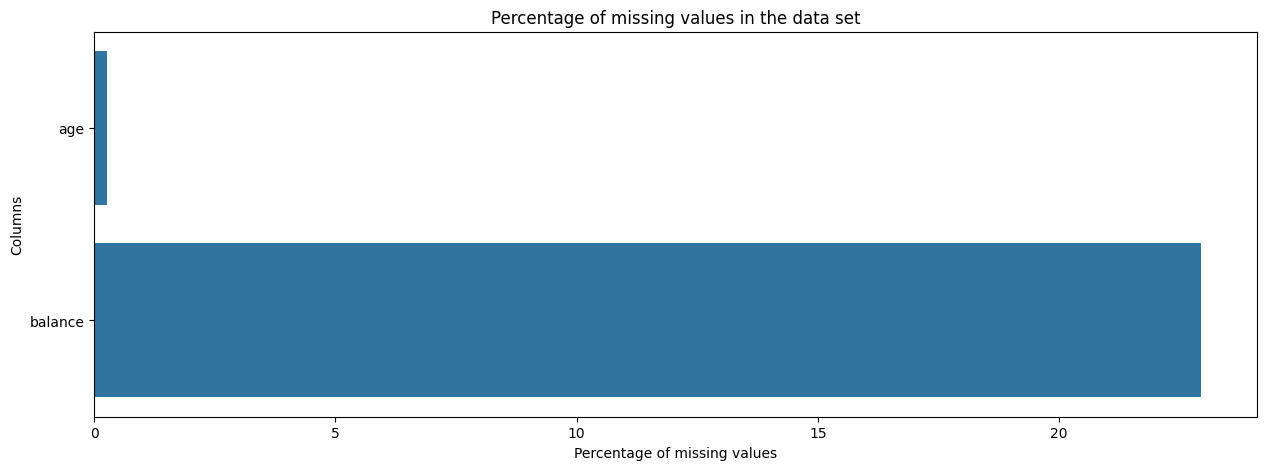

In [6]:
# Calculate the percentage of missing values
missing_percent = df.isnull().sum() * 100 / len(data)

# Create a DataFrame for plotting the graph
missing_percent = pd.DataFrame({'column': missing_percent.index, 'missing_percentage': missing_percent.values})

# Filter out columns with zero missing values
missing_percent = missing_percent[missing_percent['missing_percentage'] > 0]

# Create a histogram
plt.figure(figsize=(15, 5))
sns.barplot(x='missing_percentage', y='column', data=missing_percent)
plt.title('Percentage of missing values in the data set')
plt.xlabel('Percentage of missing values')
plt.ylabel('Columns')
plt.show()

From the results obtained, the following number of values are missing in two columns of our dataset:

* The `age` column has 26 missing values: This is not too large a number considering the total number of values in the data (10,000), but it is still worth paying attention to before conducting an analysis in which age may be a significant factor. The treatment of these values will be done next.

* The `balance` column has significantly more missing values, 2,295: This is a larger proportion of our data (almost 23% of the total number of records). It is very important to understand why this data is missing. Are these customers who never had an account balance (i.e., they never deposited money), or was it simply not recorded? The strategy for dealing with missing values will depend on this understanding. 

Next, we use the describe() function, which provides a statistical summary for the numeric columns, including the quantity, mean, standard deviation, minimum value, 25%, 50% (median), 75% quantile, and maximum value. This provides insight into the distribution of the data and possible outliers.

In [7]:
df.describe().round().T

,count,mean,std,min,25%,50%,75%,max
USERID,10000.0,171815.0,33708.0,94561.0,142810.0,172728.0,201262.0,229145.0
score,10000.0,849.0,65.0,642.0,802.0,853.0,900.0,1000.0
age,9974.0,43.0,12.0,18.0,33.0,40.0,51.0,86.0
equity,10000.0,3.0,2.0,0.0,0.0,3.0,4.0,9.0
balance,7705.0,827794.0,1980614.0,0.0,295554.0,524272.0,980706.0,119113552.0
products,10000.0,2.0,1.0,0.0,1.0,2.0,2.0,5.0
credit_card,10000.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
last_activity,10000.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
EST_SALARY,10000.0,147867.0,139389.0,2546.0,75252.0,119658.0,174501.0,1395064.0
churn,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Using the describe() method, we can draw a few conclusions about the numeric columns in our dataset:

* The values of the `score` column range from 642 to 1000. The mean and median values are very close (mean is 849 and median is 853), indicating that the distribution is symmetric.

* Age ranges from 18 to 86 years old, which may indicate that the customers of this bank are both young and old. The mean value of approximately 43 and the median value of 40 indicate that the bank caters mainly to middle-aged customers.

* The number of ownership scores (`equity' column) range from 0 to 9, with the mean and median being 3. This indicates an average distribution.

* In the `balance` column, the data varies widely, with the minimum value being 0 and the maximum being 119,113,552. The median is well below the mean, indicating a right-sided distribution (many low values, but there are a few very high values).

* The `products' column ranges from 0 to 5, the mean and median are 2, indicating that most customers use about 2 products.

* Columns `credit_card`, `last_activity` and `churn` are binary (values of 0 or 1).

* Values for `EST_SALARY` range from 2,546 to 1,395,064. The mean (147,867) is higher than the median (119,658), so the wage distribution may be right-sided, similar to a balance.

Let's construct a box plot for our data to determine if there are outliers.

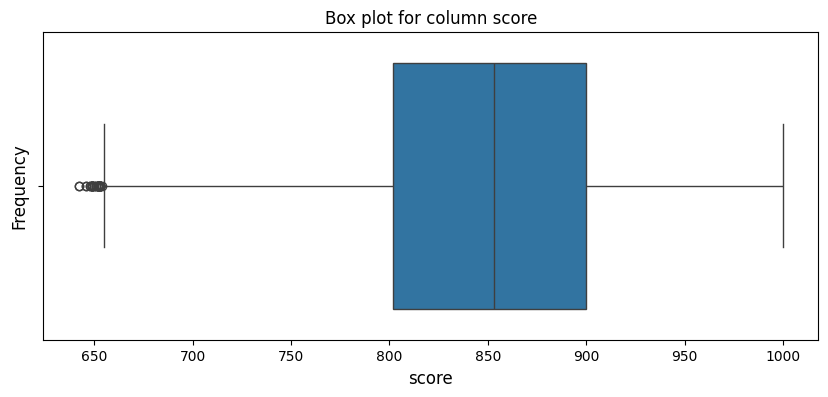

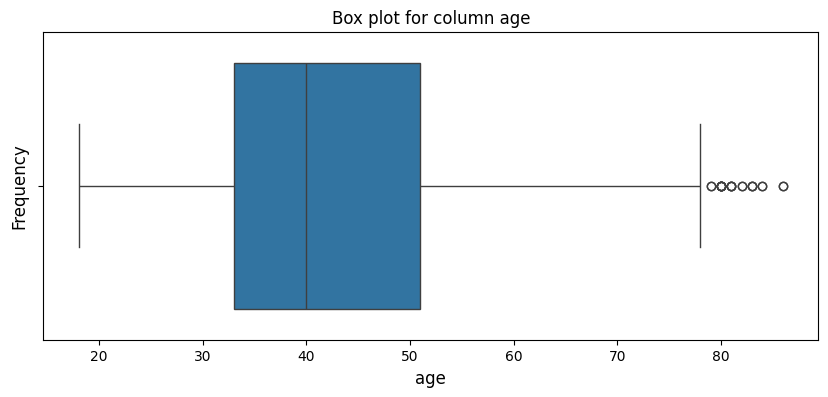

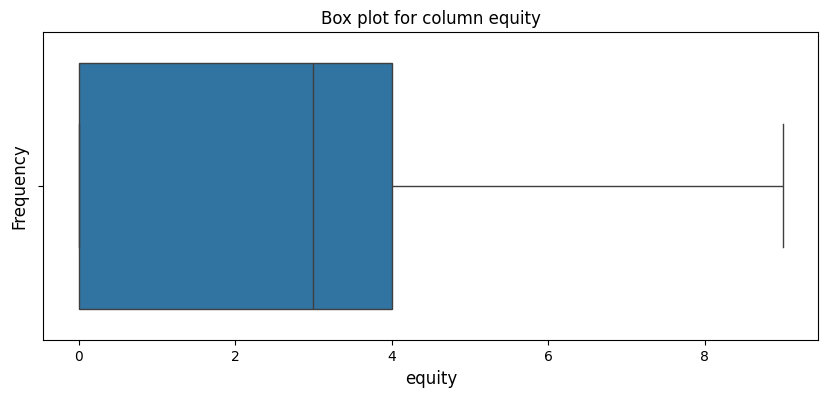

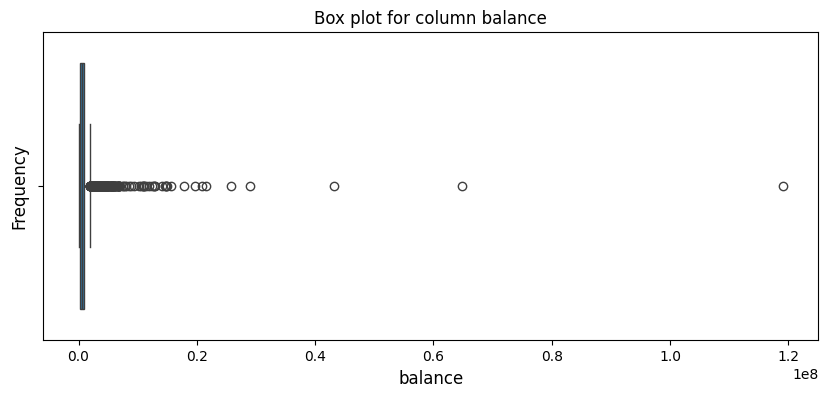

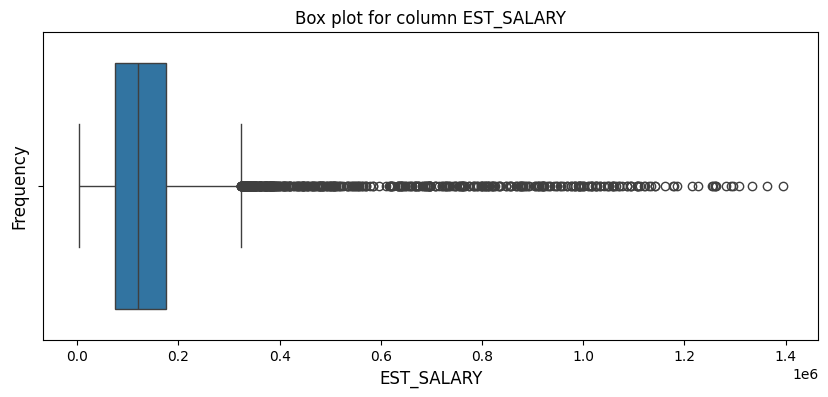

In [8]:
# Data columns for building box plots
cols_to_plot = ['score', 'age', 'equity', 'balance', 'EST_SALARY']

def create_boxplot(data, cols_to_plot):
    for col in cols_to_plot:
        plt.figure(figsize=(10, 4))
        sns.boxplot(x=df[col])
        plt.title('Box plot for column '+col)
        plt.xlabel(col, fontsize=12) # x-axis caption
        plt.ylabel('Frequency', fontsize=12) # y-axis caption
        plt.show()

# Build box plots
create_boxplot(data, cols_to_plot)

In [9]:
# Create a function to calculate upper and lower bounds for outliers
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Check for outliers in the specified columns
cols_to_check = ['score', 'age', 'equity', 'balance', 'EST_SALARY']
for column in cols_to_check:
    lower_bound, upper_bound = detect_outliers(df, column)
    print(f"For column {column}, values below {round(lower_bound, 2)} and above {round(upper_bound, 2)} are considered outliers.")

    # Output outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Number of outliers in column {column}: {outliers.shape[0]}")
    print()

For column score, values below 655.0 and above 1047.0 are considered outliers.
Number of outliers in column score: 33

For column age, values below 6.0 and above 78.0 are considered outliers.
Number of outliers in column age: 22

For column equity, values below -6.0 and above 10.0 are considered outliers.
Number of outliers in column equity: 0

For column balance, values below -732173.38 and above 2008433.38 are considered outliers.
Number of outliers in column balance: 428

For column EST_SALARY, values below -73621.06 and above 323373.51 are considered outliers.
Number of outliers in column EST_SALARY: 482



We will look at emissions in more detail after preprocessing the data.

<a id="num14"></a>
### 1.4 Intermediate output

The data and necessary libraries were downloaded for further analysis. A high value of omissions in the balance column and its right-handed distribution was revealed. The same distribution has data in the client's estimated income column.

Tasks for the next stage:

1. Correct the data type in some columns;
2. Bring the column names to lower case;
3. Handle omissions in the data;
4. Handle explicit and implicit duplicates;
5. Examine in more detail the outliers after data processing;
6. Encode values in the city and gender columns.

<a id="num2"></a>
## 2. Data preparation

<a id="num21"></a>
### 2.1 Analyzing the nature of omissions

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


* Column `age`:

There are 26 missing values, which is a small fraction of the data set. We observe a small negative correlation between age and the `credit_card` variable. These missing values could be due to errors or omissions in data recording. Given the small number of missing values and the weak correlation with other variables, we can assume that the missing age data is MCAR. Let's remove these data.

* Column `balance`:

There are quite a few missing values in this column (2,295). The missing data here can be due to two reasons: Either these customers never maintained a balance in their accounts (balance is 0), or the balance data was not obtained correctly due to some data collection problems. In any case, since this indicator is positively correlated with `score` and `EST_SALARY` indicators, omissions in this column can be considered as MAR (missing at random). Missing data in this case may introduce bias in the data analysis.

To handle `balance`, an option may be to treat `NaN` as another category and create a dummy variable indicating whether the balance value was missing or not. Then use this attribute as a column of a summary table where a measure of central tendency will be computed for each attribute. In this way we can find the dependencies of omissions on the data or confirm their absence. But first, let's remove the omissions from the `age` column.

In [11]:
# Let's remember the length of the dataframe for further checking of the percentage of deleted data
date_length_before = len(df)
date_length_before

10000

In [12]:
# Remove NaN from the 'age' column
df = df.dropna(subset=['age']) 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9974 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         9974 non-null   int64  
 1   score          9974 non-null   float64
 2   city           9974 non-null   object 
 3   gender         9974 non-null   object 
 4   age            9974 non-null   float64
 5   equity         9974 non-null   int64  
 6   balance        7695 non-null   float64
 7   products       9974 non-null   int64  
 8   credit_card    9974 non-null   int64  
 9   last_activity  9974 non-null   int64  
 10  EST_SALARY     9974 non-null   float64
 11  churn          9974 non-null   int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 1013.0+ KB


In [13]:
# Check the percentage of deleted data from the dataset
date_length_after = len(data)
percent_dropna_values = 100 - ((date_length_after/date_length_before)*100)
print('Percentage of deleted data:', round(percent_dropna_values, 3),'%')

Percentage of deleted data: 0.0 %


Let's calculate central tendencies to test the dependence of omissions in the `balance` column on other variables. 

In [14]:
# Создаем новый столбец где указываем 1, если в 'balance' есть NaN, 0 в противном случае
df = df.copy()
df['IS_BALANCE_MISSING'] = df['balance'].isnull().astype(int)

summary_table = pd.DataFrame()

# Расчет средних значений
for column in ['EST_SALARY', 'age', 'balance', 'score']:
    summary_table.loc[column, 'Value Missing'] = df.loc[df['IS_BALANCE_MISSING']==1, column].mean()
    summary_table.loc[column, 'Value Not Missing'] = df.loc[df['IS_BALANCE_MISSING']==0, column].mean()

# Расчет относительной разницы
for column in ['EST_SALARY', 'age', 'balance', 'score']:
    summary_table.loc[column, 'Relative Difference'] = (summary_table.loc[column, 'Value Not Missing'] - summary_table.loc[column, 'Value Missing']) / summary_table.loc[column, 'Value Missing']

# Расчет медианных значений
for column in ['products', 'equity']:
    summary_table.loc[column, 'Value Missing'] = df.loc[df['IS_BALANCE_MISSING']==1, column].median()
    summary_table.loc[column, 'Value Not Missing'] = df.loc[df['IS_BALANCE_MISSING']==0, column].median()

# Расчет моды
for column in ['city', 'gender']:
    summary_table.loc[column, 'Value Missing'] = df.loc[df['IS_BALANCE_MISSING']==1, column].mode()[0]
    summary_table.loc[column, 'Value Not Missing'] = df.loc[df['IS_BALANCE_MISSING']==0, column].mode()[0]

summary_table

C:\Users\Shiro\AppData\Local\Temp\ipykernel_3324\517682787.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Ярославль' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_table.loc[column, 'Value Missing'] = df.loc[df['IS_BALANCE_MISSING']==1, column].mode()[0]
C:\Users\Shiro\AppData\Local\Temp\ipykernel_3324\517682787.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Ярославль' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_table.loc[column, 'Value Not Missing'] = df.loc[df['IS_BALANCE_MISSING']==0, column].mode()[0]


,Value Missing,Value Not Missing,Relative Difference
EST_SALARY,226345.417464,124520.394264,-0.449866
age,42.093023,42.924366,0.019750
balance,NaN,827245.587515,NaN
score,865.357174,843.74412,-0.024976
products,1.0,2.0,NaN
equity,0.0,4.0,NaN
city,Ярославль,Ярославль,NaN
gender,М,Ж,NaN


**The following observations and conclusions can be drawn from the summary table:**

* **Correlation between missing balance and wages:** 

The mean estimated wages for those with missing balance values are significantly higher (approximately 226 345.42) compared to those with no missing balance (approximately 124 520.39). This may suggest that the dataset may be missing balance information specifically for higher income individuals. However, more statistical analysis is needed to confirm this potential relationship.

* **Age distribution:** 

The age distribution between those with missing balance values and those with missing values appears to be relatively similar, with a small relative difference of about 0.02. This suggests that age ***is not a ***significant factor* affecting missing balance information.

* **The number of property scores and the number of products:** 

There is a notable difference in the median values of equity and products between the cases with and without missing balance sheet information. However, again, it is difficult to determine the exact correlation and impact.

* **Gender and City:** 

Both categories do not change depending on whether the balance sheet is missing or not. This may indicate that **lack of balance is **independent** on the attributes "gender" and "city."

It should be kept in mind that these patterns may indicate either an underlying correlation relationship or a random omission.

Plot the percentage of missing values in the `balance` column as a function of the other column. Such relationships between variables can help us conclude whether our missing values are MAR (Missing At Random).

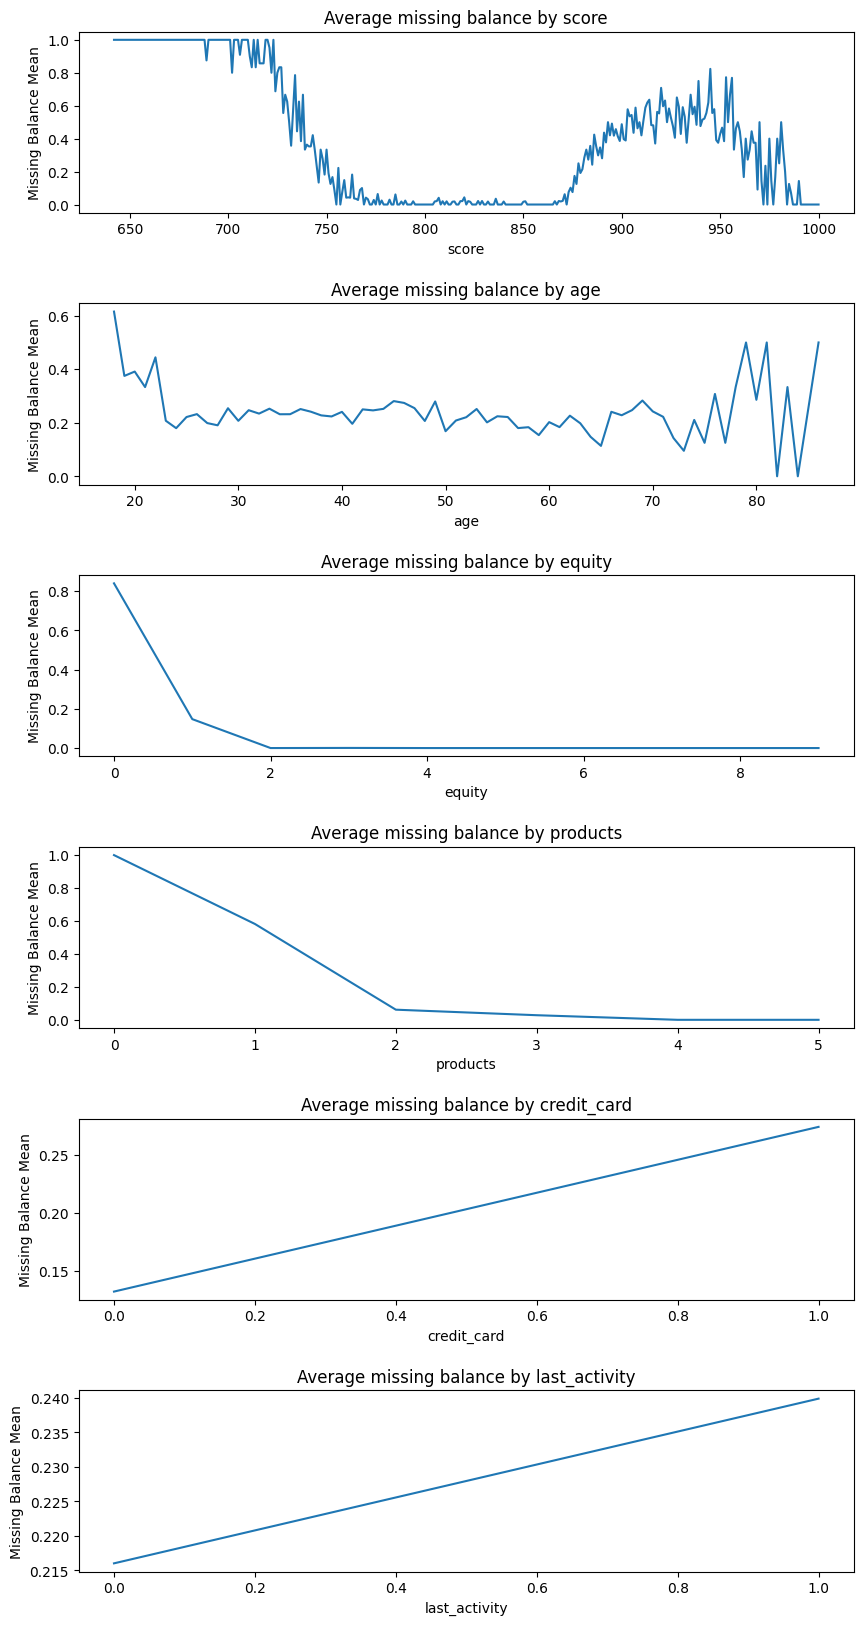

In [15]:
columns_to_plot = ['score', 'age', 'equity', 'products', 'credit_card', 'last_activity']

fig, axs = plt.subplots(len(columns_to_plot), figsize=(10, 20))
fig.subplots_adjust(hspace = 0.5, wspace=.2)

for i, col in enumerate(columns_to_plot):
    axs[i].plot(df.groupby(col)['IS_BALANCE_MISSING'].mean())
    axs[i].set_title(f'Average missing balance by {col}')
    axs[i].set_xlabel(f'{col}')
    axs[i].set_ylabel('Missing Balance Mean')

plt.show()

From these graphs, it can be seen that balance skips are related to other variables. 

* For example, the percentage of skips in `balance' varies with the value of `score'. A lower `score` value tends to have a higher skip percentage, while a higher `score` value tends to have a lower skip percentage. Such a pattern rarely occurs by chance. Therefore, it is likely that data are missing depending on `score`, which is a kind of MAR situation. 

* When `equity` is zero, the probability that `balance` is missing is about 84%. If `equity` is one, the probability drops to about 15%, and if `equity` is two or higher, `balance` is never absent. This is indicative of Missing At Random (MAR), since the omission of the `balance` value depends on the `equity` value. 

A similar situation is observed with slave variables. 

Let's see if we can fill in the missing data in the `balance` column using machine learning methods. For this purpose, we apply RandomForestRegressor, GradientBoostingRegressor and LinearRegression methods to our data and determine the metrics (RMSE, R-squared score, MSE, MAE, Median Absolute Error) of the predicted data quality. 

In [16]:
# Retain the actual columns
columns_to_retain = ['age', 'equity', 'score', 'EST_SALARY', 'products', 'balance']
data = df[columns_to_retain]

# Split the data into sets: with known and unknown 'balance'.
known = data[data.balance.notnull()]
unknown = data[data.balance.isnull()]

# Prepare the known dataset
X = known.values[:,:-1]
y = known.values[::,-1]

# Split the dataset into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare models
models = {
    "RandomForestRegressor": RandomForestRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "LinearRegression": LinearRegression()
}

# Go through the models and get RMSE, R2, MSE, MAE and MedAE
for model_name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    rms = sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    medae = median_absolute_error(y_test, pred)
    print(f'{model_name} metrics:')
    print(f'RMSE: {rms}')
    print(f'R-squared score: {r2}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'Median Absolute Error: {medae}\n')

RandomForestRegressor metrics:
RMSE: 3071298.1479698555
R-squared score: 0.04011340470382685
MSE: 9432872313723.064
MAE: 434564.4554367772
Median Absolute Error: 224107.20349999995

GradientBoostingRegressor metrics:
RMSE: 3062611.537608001
R-squared score: 0.045535456849286504
MSE: 9379589430289.645
MAE: 429293.4317709453
Median Absolute Error: 225542.5906402776

LinearRegression metrics:
RMSE: 3076778.151564726
R-squared score: 0.03668496857470804
MSE: 9466563793946.053
MAE: 520287.54472256295
Median Absolute Error: 315852.482012543



From the results we can see that all models predict the result poorly. Therefore, the option of filling in the gaps using machine learning is not suitable for our data. We will leave the gaps as they are and analyze them with this information in mind. 

<a id="num22"></a>
### 2.2 Pre-processing

<a id="num221"></a>
#### 2.2.1 Data type processing

Bring the column names to lower case and change the data type of some columns to a more appropriate one.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9974 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   USERID              9974 non-null   int64  
 1   score               9974 non-null   float64
 2   city                9974 non-null   object 
 3   gender              9974 non-null   object 
 4   age                 9974 non-null   float64
 5   equity              9974 non-null   int64  
 6   balance             7695 non-null   float64
 7   products            9974 non-null   int64  
 8   credit_card         9974 non-null   int64  
 9   last_activity       9974 non-null   int64  
 10  EST_SALARY          9974 non-null   float64
 11  churn               9974 non-null   int64  
 12  IS_BALANCE_MISSING  9974 non-null   int32  
dtypes: float64(4), int32(1), int64(6), object(2)
memory usage: 1.0+ MB


In [18]:
# Convert column names to lower case
df.columns = map(str.lower, df.columns)

In [19]:
# Change the column data type to int64
df['score'] = df['score'].astype('int64')
df['age'] = df['age'].astype('int64')

In [20]:
# Check the result.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9974 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   userid              9974 non-null   int64  
 1   score               9974 non-null   int64  
 2   city                9974 non-null   object 
 3   gender              9974 non-null   object 
 4   age                 9974 non-null   int64  
 5   equity              9974 non-null   int64  
 6   balance             7695 non-null   float64
 7   products            9974 non-null   int64  
 8   credit_card         9974 non-null   int64  
 9   last_activity       9974 non-null   int64  
 10  est_salary          9974 non-null   float64
 11  churn               9974 non-null   int64  
 12  is_balance_missing  9974 non-null   int32  
dtypes: float64(2), int32(1), int64(8), object(2)
memory usage: 1.0+ MB


<a id="num222"></a>
#### 2.2.2 Duplicate Processing

Handle explicit and implicit duplicates in the dataframe.

In [21]:
# Check for obvious duplicates
duplicates = df[df.duplicated()]
number_of_duplicates = len(duplicates)
percentage_of_duplicates = number_of_duplicates / len(df) * 100

print(f"Number of duplicates: {number_of_duplicates}")
print(f"Percentage of duplicates: {percentage_of_duplicates}%")

Number of duplicates: 0
Percentage of duplicates: 0.0%


In [22]:
# Check for implicit duplicates in the 'userid' column
implicit_duplicates = df[df.duplicated(subset='userid')]
number_of_implicit_duplicates = len(implicit_duplicates)
percentage_of_implicit_duplicates = number_of_implicit_duplicates / len(df) * 100

print(f"Number of implicit duplicates in userid: {number_of_implicit_duplicates}")
print(f"Percentage of implicit duplicates in userid: {round(percentage_of_implicit_duplicates, 2)}%")

Number of implicit duplicates in userid: 50
Percentage of implicit duplicates in userid: 0.5%


The number of implicit duplicates in a dataframe is small, but it's worth examining them in more detail. 

In [23]:
implicit_duplicates.head(5)

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,is_balance_missing
1583,190253,726,Ярославль,М,49,0,NaN,1,1,1,177700.78,0,1
1837,210662,896,Рыбинск,Ж,37,0,NaN,2,0,0,90916.04,0,1
2138,131419,739,Рыбинск,Ж,37,3,1307941.65,3,0,0,103867.47,0,0
2302,220816,934,Рыбинск,Ж,74,5,1294285.39,3,1,0,95606.80,0,0
2998,208081,821,Рыбинск,Ж,62,3,493608.26,2,1,1,33491.45,0,0


In [24]:
df[df['userid'] == 190253]

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,is_balance_missing
231,190253,823,Рыбинск,М,37,4,373348.39,2,0,1,131947.92,1,0
1583,190253,726,Ярославль,М,49,0,NaN,1,1,1,177700.78,0,1


In [25]:
df[df['userid'] == 210662]

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,is_balance_missing
869,210662,962,Ярославль,Ж,54,5,5069231.39,1,1,1,955144.85,1,0
1837,210662,896,Рыбинск,Ж,37,0,NaN,2,0,0,90916.04,0,1


Users with the same id have different information on other columns. These users may have been mistakenly recorded under the same id. The solution for such duplicates is to assign a new unique identifier to these users.

In [26]:
duplicated_ids = df[df.duplicated(subset='userid')]['userid'].unique()

for userid in duplicated_ids:
    mask = df['userid'] == userid
    first_occurrence = df.loc[mask].index[0]
    duplicate_indices = df.loc[mask].index[1:]
    for dup_index in duplicate_indices:
        df.at[dup_index, 'userid'] = df['userid'].max() + 1

In [27]:
df[df.duplicated(subset='userid')]

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,is_balance_missing


There are no more duplicates in the column. 

<a id="num223"></a>
#### 2.2.3 Emission processing

Let's look at the emissions in the data in more detail.

In [28]:
def detect_outliers(dataframe):
    cols = list(dataframe)
    outliers = {'Feature':[],'Number of Outliers':[]}
    
    for column in cols:
        if column in dataframe.select_dtypes(include=np.number).columns:
            # первый квартиль (Q1)
            q1 = dataframe[column].quantile(0.25) 
                   
            # третий квартиль (Q3)
            q3 = dataframe[column].quantile(0.75)
            
            # IQR = Q3 - Q1
            iqr = q3 - q1
            
            fence_low = q1 - (1.5*iqr)
            fence_high = q3 + (1.5*iqr)
            
            outliers['Feature'].append(column)
            outliers['Number of Outliers'].append(dataframe.loc[(dataframe[column] < fence_low) | (dataframe[column] > fence_high)].shape[0])
    
    outliers_df = pd.DataFrame(outliers)
    
    return outliers_df

outliers_df = detect_outliers(df)

# Calculate the total number and percentage of deviating values
total_outliers = outliers_df['Number of Outliers'].sum()
total_values = np.product(df.shape)

print(f"Total Emissions: {total_outliers}")
print(f"Percentage of emissions in the entire dataset: {round(((total_outliers/total_values)*100), 2)}%")

# Let's derive the percentage of emissions in each column
outliers_df['Percentage of Outliers'] = ((outliers_df['Number of Outliers'].astype(float) / df.shape[0]) * 100).round(2)
outliers_df

Total Emissions: 5552
Percentage of emissions in the entire dataset: 4.28%


,Feature,Number of Outliers,Percentage of Outliers
0,userid,0,0.00
1,score,33,0.33
2,age,22,0.22
3,equity,0,0.00
4,balance,427,4.28
5,products,493,4.94
6,credit_card,0,0.00
7,last_activity,0,0.00
8,est_salary,479,4.80
9,churn,1819,18.24


Let's take a closer look at how our data is distributed using a histogram and quantile-quantile (QQ) plot. 

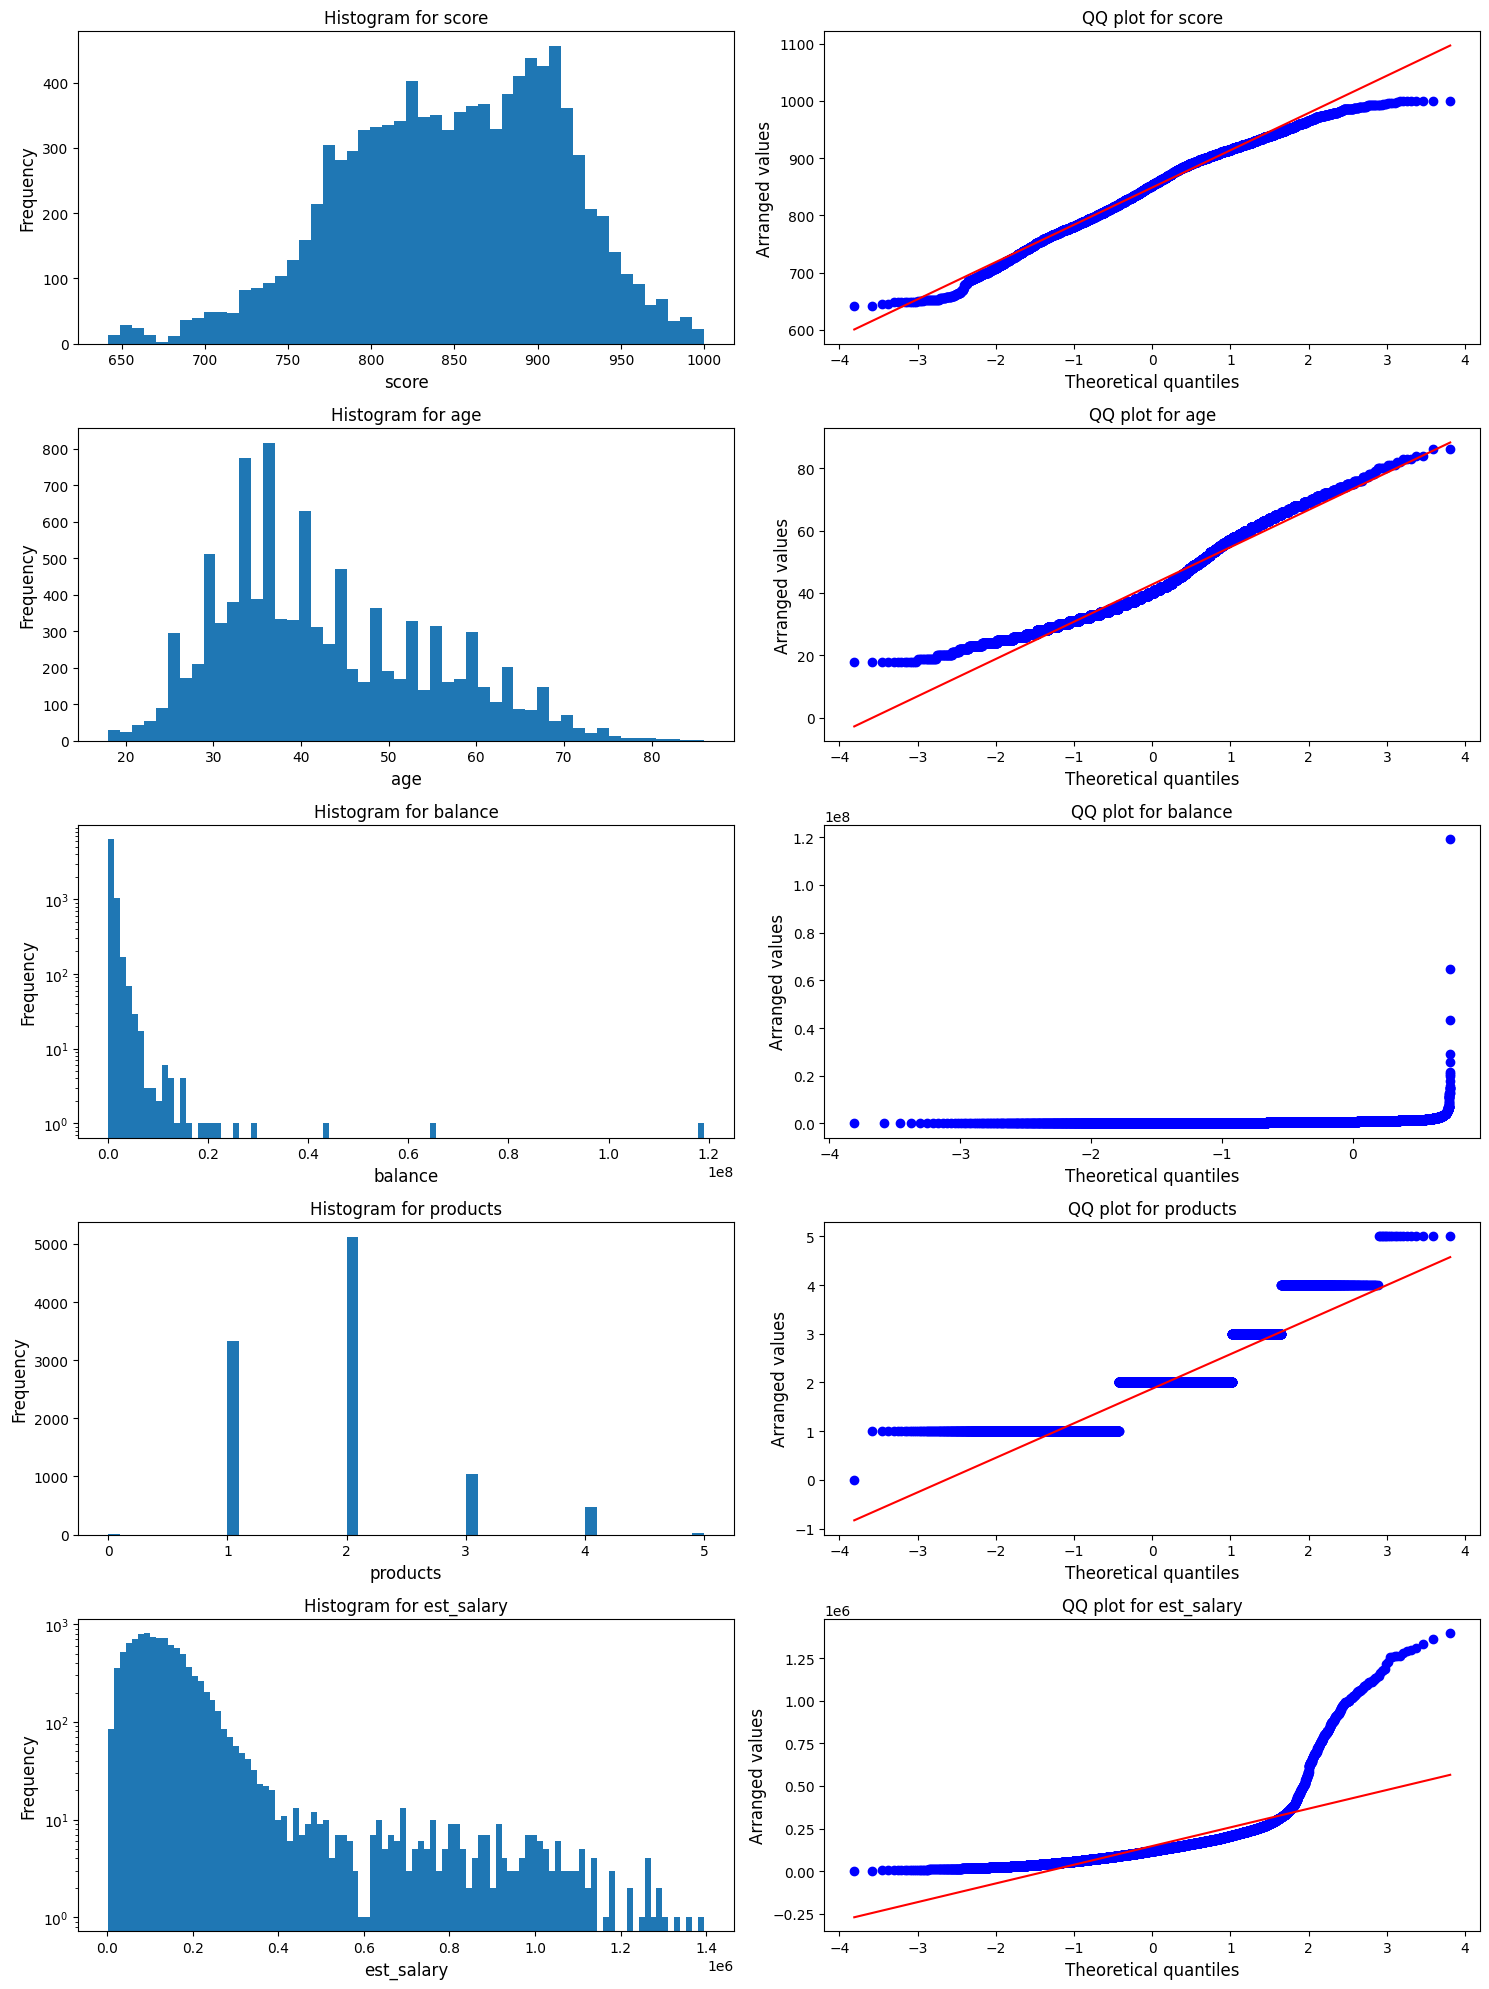

In [29]:
columns = ['score', 'age', 'balance', 'products', 'est_salary']
bins = [50, 50, 100, 50, 100]
logs = [False, False, True, False, True]

fig, axs = plt.subplots(len(columns), 2, figsize=(15, 20))

for i, (column, bin, log) in enumerate(zip(columns, bins, logs)):
    # Create a histogram

    axs[i,0].hist(df[column], bins=bin, log=log)
    axs[i,0].set_title('Histogram for {}'.format(column))
    axs[i,0].set_xlabel(column, fontsize=12)    # x-axis caption
    axs[i,0].set_ylabel('Frequency', fontsize=12) # y-axis caption 

    # Creating a QQ chart
    stats.probplot(df[column], dist="norm", plot=axs[i,1])
    axs[i,1].set_title('QQ plot for {}'.format(column))
    axs[i,1].set_xlabel('Theoretical quantiles', fontsize=12) 
    axs[i,1].set_ylabel('Arranged values', fontsize=12) 

plt.tight_layout()
plt.show()

Let's take a closer look at users with very large account balances.

In [30]:
sorted_df = df.sort_values(by='balance', ascending=False)
sorted_df.head(10)

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,is_balance_missing
7597,156149,900,Ярославль,М,62,5,1.191136e+08,2,1,1,138041.31,0,0
1059,114103,894,Ярославль,М,58,4,6.486621e+07,2,1,1,88861.60,1,0
1846,114088,927,Ярославль,М,57,5,4.327710e+07,3,0,1,82619.00,0,0
4721,228786,1000,Ярославль,М,45,5,2.900893e+07,2,0,1,811804.54,0,0
9753,122015,885,Ярославль,М,64,4,2.572776e+07,3,1,0,168746.90,0,0
8484,221720,1000,Ярославль,Ж,35,5,2.154994e+07,2,0,0,1051902.65,0,0
6948,137434,1000,Ярославль,М,37,4,2.090616e+07,2,1,1,947606.60,1,0
125,227092,1000,Ярославль,М,32,5,1.975718e+07,2,1,1,1024626.50,0,0
7109,203824,986,Ярославль,М,34,5,1.790476e+07,2,1,1,856500.86,1,0
4005,163640,912,Ярославль,М,35,4,1.562410e+07,2,0,1,1395064.45,0,0


Let's see how much data we lose if we decide to remove the outliers in the balance column.

In [31]:
Q1 = df['balance'].quantile(0.25)
Q3 = df['balance'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

removed_outliers = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

data_loss = (df.shape[0] - removed_outliers.shape[0]) / df.shape[0] * 100

print(f"Percentage of data loss: {round(data_loss, 2)}%")

Percentage of data loss: 27.13%


Conclusion: The percentage of data loss is too high. 

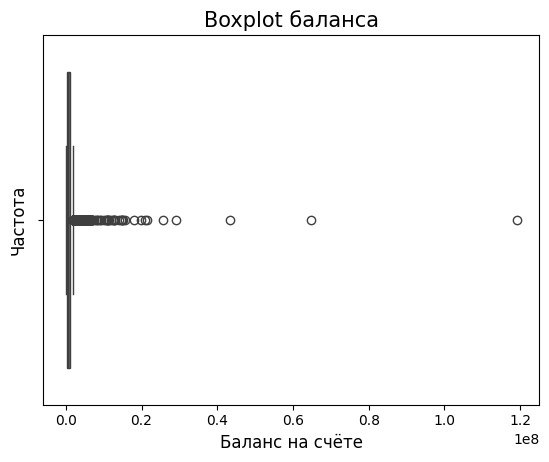

In [32]:
sns.boxplot(x=df["balance"])
plt.xlabel('Баланс на счёте', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.title('Boxplot баланса', fontsize=15)
plt.show()

In the future, when we graph the balance to churn ratio, we will limit our data by removing too "rich" customers, so that the resulting graph will be more illustrative.

In the dataset, outliers are observed in score, age, balance, products, est_salary and churn. However, these values look realistic, especially in a banking context.

* Credit scoring (`score`): Credit scores can have a wide range depending on the users' credit history. The organizations that calculate them have proprietary algorithms that can cause wide variation, and thus failures may not be real errors.


* Age (`age`): The average age of bank customers can have a wide range due to different types of users. Bank customers can be young people as well as elderly.


* Balance in the account (`balance`): The balance in the account can vary significantly from one user to another as it largely depends on the income, savings habit and other socio-economic factors of the customer.


* Number of products used by the customer (`products`): The number of products, may be large for some customers based on their needs. Some customers may use many banking products, so this indicator may not necessarily be an outlier.


* Estimated client income (`est_salary`): Estimated earnings can also have a significant range as incomes vary widely across the population.


* Sign of churn (`churn`): It is quite reasonable to have an unbalanced churn rate, as generally in a stable business only a fraction of customers churn in a given period.


Thus, deviation from the mean does not necessarily characterize these values as "outliers" in the practical sense, since they may be the result of natural variations in the data.

<a id="num23"></a>
### 2.3 Coding

Let's encode the data in the `city` and `gender` columns.

In [33]:
# Create a new column as a copy of the original column

df['gender_encoded'] = df['gender']

gender_mapping = {'Ж': 0, 'М': 1}

# Use matches to code the required columns
df['gender_encoded'] = df['gender_encoded'].map(gender_mapping)

In [34]:
df.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,is_balance_missing,gender_encoded
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,0,0
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,0,0
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,1,0
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,0,0
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,1


In [35]:
# Create a DataFrame for each column that needs to be converted
city_encoded = pd.get_dummies(df['city'], prefix='city')

# Save the original DataFrame, add the encoded columns
df = df.join([city_encoded])

# Show the first few rows of the new DataFrame
df.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,is_balance_missing,gender_encoded,city_Ростов,city_Рыбинск,city_Ярославль
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,0,0,False,True,False
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,0,0,False,True,False
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,1,0,False,True,False
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,0,0,False,False,True
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,1,False,False,True


<a id="num24"></a>
### 2.4 Intermediate output

The following data preprocessing steps were performed:

1. Removed 26 missing values in the `age` column;
2. Column names were made lower case;
3. Changed the data types to more appropriate ones;
4. Handled 50 implicit duplicates in the `userid` column;
5. Examined omissions in the `balance` column;
6. Coded data in the `city` and `gender` columns.

<a id="num3"></a>
## 3. Exploratory Data Analysis (EDA)

<a id="num31"></a>
### 3.1 Identifying significant signs of outflow

Let's plot the outflow graphs:

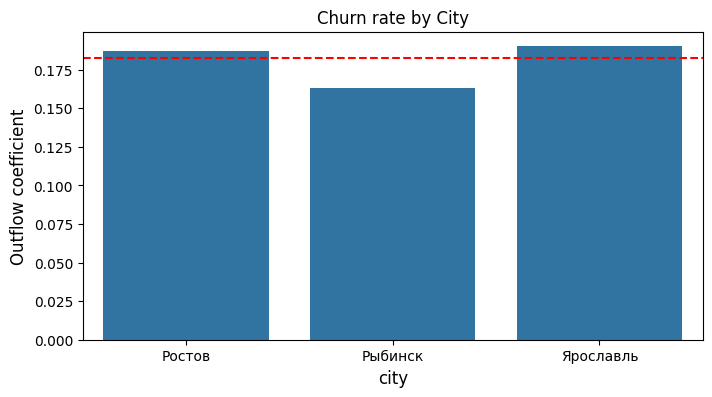

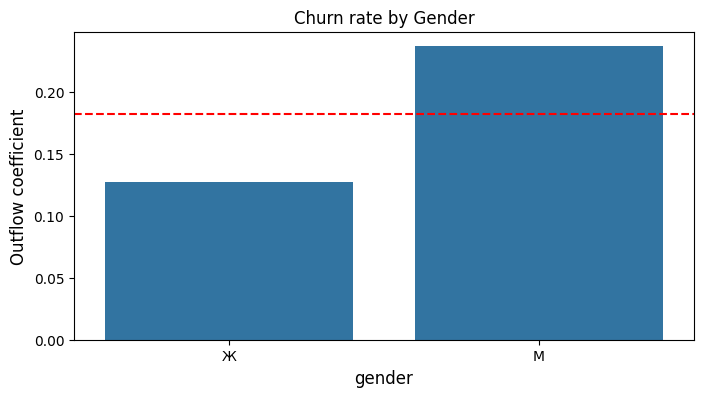

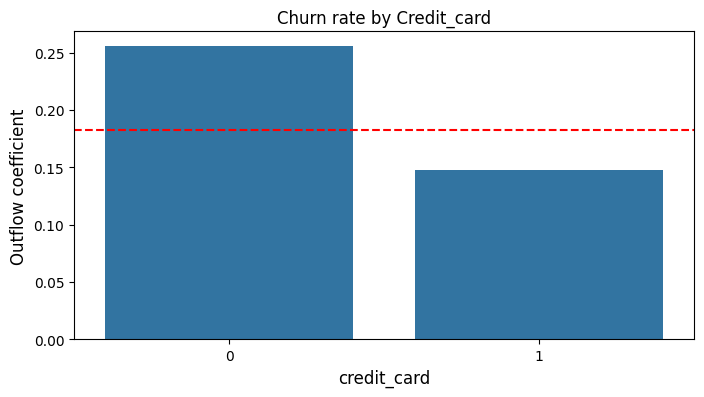

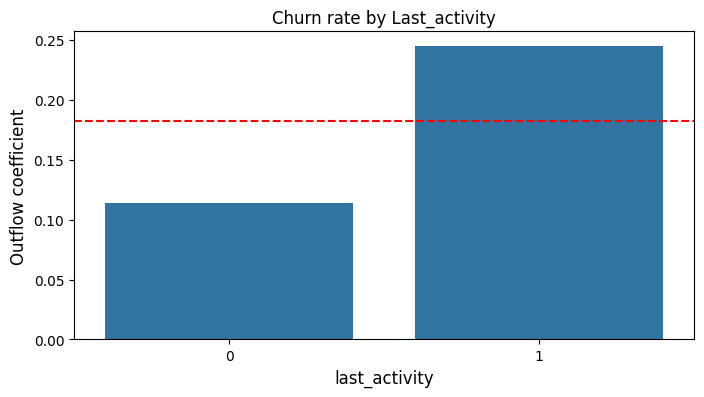

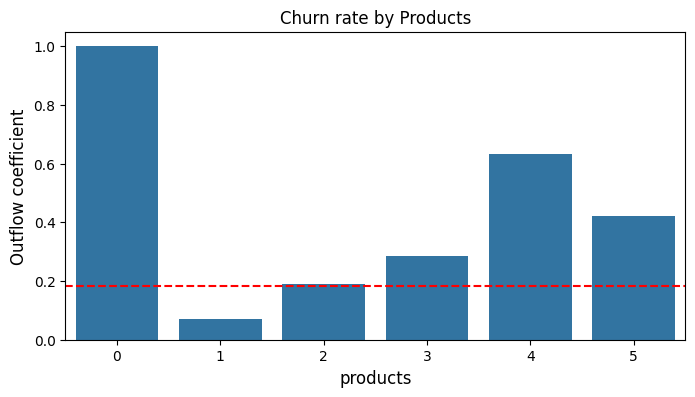

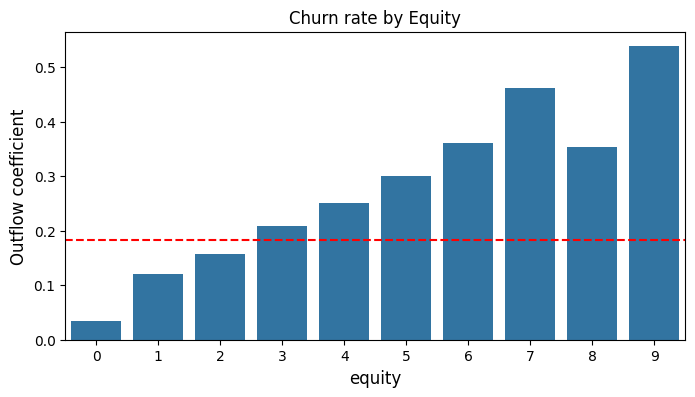

In [36]:
categorical_vars = ['city', 'gender', 'credit_card', 'last_activity', 'products', 'equity']

for var in categorical_vars:
    # churn rate calculation
    churn_rate = df.groupby(var)['churn'].mean().reset_index()

    plt.figure(figsize=(8, 4))
    sns.barplot(x=var, y='churn', data=churn_rate)
    plt.title(f'Churn rate by {var.capitalize()}')
    plt.axhline(df['churn'].mean(), color='red', linestyle='dashed')
    
    # axis captions
    plt.xlabel(var, fontsize=12) # x-axis caption
    plt.ylabel('Outflow coefficient', fontsize=12) # y-axis caption

    plt.show()

Let us take a closer look at the anomalous value in products = 0

In [37]:
df.groupby('products')['churn'].count()

products
0       1
1    3323
2    5119
3    1038
4     474
5      19
Name: churn, dtype: int64

In [38]:
df[df['products'] == 0]

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,is_balance_missing,gender_encoded,city_Ростов,city_Рыбинск,city_Ярославль
8957,147837,962,Рыбинск,Ж,79,3,NaN,0,0,0,25063.96,1,1,0,False,True,False


There is only one abnormal value, and it can be safely deleted.

In [39]:
df = df[df['products'] != 0]

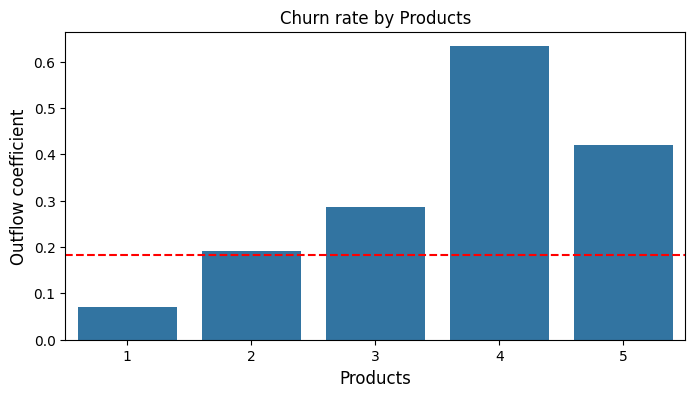

In [40]:
# churn rate calculation
churn_rate = df.groupby('products')['churn'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(x='products', y='churn', data=churn_rate)
plt.title(f'Churn rate by Products')
plt.axhline(df['churn'].mean(), color='red', linestyle='dashed')

# axis captions
plt.xlabel('Products', fontsize=12) # x-axis caption
plt.ylabel('Outflow coefficient', fontsize=12) # y-axis caption

plt.show()

Here, the red dashed line represents the average outflow level. If the bar exceeds this line, it means that the outflow level for this category is higher than average.

**General conclusions:**

1. **city**: In general, the city variable is not a strong predictor of out-migration, at least when considered separately, as out-migration rates do not differ significantly across cities.

* Yaroslavl and Rostov: These cities have an outflow coefficient of 0.19, which is slightly higher than the average for all data. This means that the probability of customer churn from these two cities is slightly higher than the average customer.

* Rybinsk: The churn rate is 0.16, which is slightly below the average (0.18). This means that the probability of customers leaving Rybinsk is slightly lower than the average customer.

2. **gender**: in this dataset, the churn rate among men is higher than among women. This suggests that gender may be a significant predictor of churn in this dataset.

* Men: the churn rate is approximately 0.237 or 23.7%, meaning that nearly one in four male customers leave.

* Women: In comparison, the churn rate is approximately 0.128, or 12.8%, indicating a significantly lower churn rate among female customers - approximately one in eight leave.

3. **credit_card**: Having a credit card can increase a customer's loyalty to the bank and reduce the likelihood of customers leaving (churn).

* Customers who do not have a credit card are more likely to churn, with a churn rate of approximately 25.58%.

* Customers who have a credit card are less likely to churn, with a churn rate of approximately 14.78%.

4. **last_activity**:

* Customers who have had any recent activity with Metanprom Bank are more likely to churn - their churn rate is approximately 24.49%. On the other hand, the churn rate of inactive customers is only 11.39%.

* In general, one would expect active customers to be less likely to churn, as sustained activity is often considered a sign of customer engagement. However, judging from the above data, this does not appear to be the case at Metanprom Bank. This counterintuitive result may reflect a situation where active customers become frustrated with the quality of service and seek alternatives.

5. **products**: churn rate decreases as the number of products a customer has decreases.

* Customers using all 4 products have a relatively high churn rate of about 63.29%.

* Customers using 5 products have a slightly lower churn rate of about 42.11%.

* Customers using 3 products have a churn rate of about 28.6%.

* Customers using 2 products have an even lower churn rate of 19.1%.

* Finally, customers using only one product have the lowest churn rate of about 7%.

6. **equity**: as the "amount of equity" increases, the churn rate of customers also increases up to a certain point, indicating that there is a positive correlation between these two indicators.

* Customers with no equity (equity = 0) have the lowest churn rate of about 3.49%. As equity increases, the churn rate increases: customers with 1 equity have a churn rate of about 12.03%, with 2 equity about 15.79%, with 3 equity about 20.89%, etc.

* The trend indicates that customers with more property are more likely to churn. This can be explained by the fact that such customers have more financial flexibility and are therefore more likely to move to competitors in search of a better offer, or perhaps they are not satisfied with their current services.

Let's plot the distribution of churn by `score`, `age`.

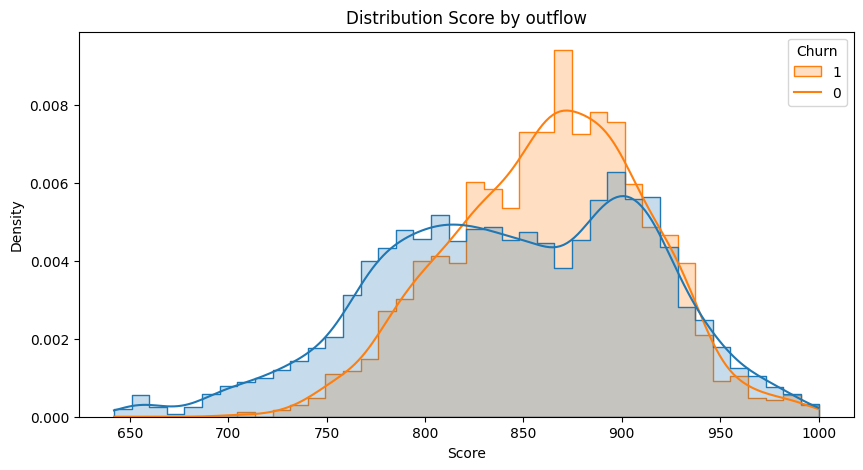

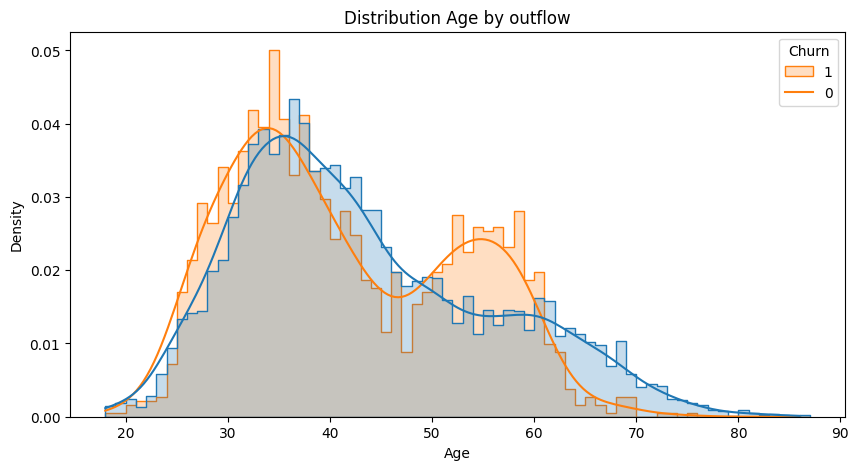

In [41]:
continuous_vars = ['score', 'age']

df_temp = df.copy()

for var in continuous_vars:
    plt.figure(figsize=(10, 5)) 
    
    if var == 'age': 
        sns.histplot(data=df_temp, x=var, hue="churn", element="step", stat="density", 
                     common_norm=False, kde=True, bins=range(int(df_temp[var].min()), int(df_temp[var].max()+2)))
    else:
        sns.histplot(data=df_temp, x=var, hue="churn", element="step", stat="density", 
                     common_norm=False, kde=True)  
    
    plt.title(f'Distribution {var.capitalize()} by outflow')
    plt.xlabel(var.capitalize())
    plt.ylabel('Density')

    plt.legend(title='Churn', loc='upper right', labels=['1', '0'])
    plt.show()

**General conclusions:**

1. **score:** there is a clear relationship between credit score and churn rate. As the credit score of a customer in a given dataset increases, the churn rate also increases.

* Customers with credit score less than 706 have zero churn rate, indicating that customers in this score range are highly loyal or they do not have better alternatives for banking services. 

* Beginning with a score of 706, the churn rate begins to increase and continues to increase overall as the score increases.

* Churn rates increase unevenly, which may be because customer churn is affected by a combination of characteristics, not just credit scores.

* At very high credit scores (980 and above), churn rates fluctuate widely. This may be due to the smaller number of customers with such high scores, making the churn rate more sensitive to the actions of individual customers.

2. **age:**

* Younger customers (18-22 years old) have relatively low churn rates (6-15%), which may indicate loyalty or less opportunity for financial mobility.

* The churn rate increases slightly between the ages of 23-27 and peaks at age 27, when the churn rate is 31%. This may be because people of this age are more likely to change their financial circumstances, such as starting a new job, moving to another city, or exploring different banking options.

* Between the ages of 28-52, the churn rate ranges from 18-34%. There is no clear pattern in this age range and fluctuations can be related to various factors such as economic situation, marital status, etc.

* After age 52, the churn rate tends to increase and peaks at age 54, when the churn rate is 34%. This may be due to the fact that people in this age range are retiring, which can lead to significant changes in banking and financial management needs.

* From age 55 onwards, the churn rate gradually declines and reaches 0% at age 70 onwards (excluding age 79). This may be because people in this age group tend to have established financial habits and are less likely to change their banking behavior.

* The fact that the churn rate at age 79 is 50% may seem unexpected. This may be due to the fact that the number of customers at this age is very small and therefore even a few churned customers may result in a high churn rate.

Let's plot the graphs for `balance`, `est_salary`.

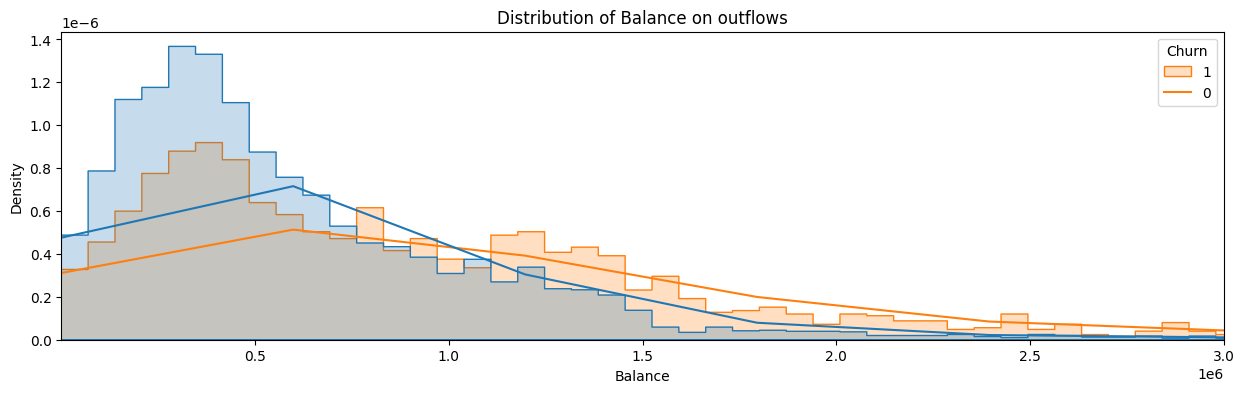

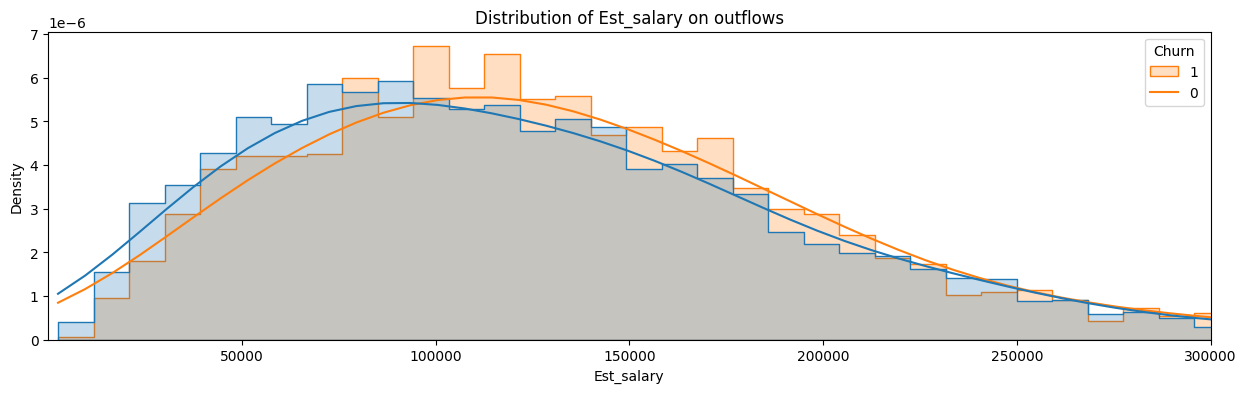

In [42]:
continuous_vars = ['balance', 'est_salary']

for var in continuous_vars:
    plt.figure(figsize=(15, 4)) 

    sns.histplot(data=df_temp, x=var, hue="churn", element="step", stat="density", 
                 common_norm=False, kde=True)  
    
    plt.title(f'Distribution of {var.capitalize()} on outflows')
    plt.xlabel(var.capitalize())
    plt.ylabel('Density')

    # Limit the x-axis for a more specific display
    if var == 'balance':
        plt.xlim(1, 3000000)
    else:
        plt.xlim(1, 300000)

    plt.legend(title='Churn', loc='upper right', labels=['1', '0'])
    plt.show()

The charts show a bias where customers caught in churn predominate.

1. **balance:** Clients with balances starting at 750k are more prone to churn than clients with smaller balances. 

2. **est_salary:** Clients who earn more than 110k are more prone to churn than clients with salaries below that amount.

Consider the summary statistics for 'balance' and 'est_salary'.

In [43]:
summary_df = pd.DataFrame()

for var in continuous_vars:
    # Calculate summary statistics for each variable grouped by churn
    summary_stats = df_temp.groupby('churn')[var].describe()
    
    # Adding the results to the summary DataFrame
    summary_df = pd.concat([summary_df, summary_stats], axis=1)

summary_df.T.round()

churn,0,1
count,5889.0,1806.0
mean,733032.0,1134458.0
std,1953952.0,2034446.0
min,0.0,6.0
25%,279655.0,387482.0
50%,475410.0,783909.0
75%,853826.0,1348128.0
max,119113552.0,64866210.0
count,8155.0,1818.0
mean,147675.0,148357.0


**General conclusions:** On average, customers who churn have higher balances and perceived wages than those who do not churn. This may indicate that customers with higher financial status are more likely to churn. It may also indicate that wealthier customers may have higher expectations or find better services or products elsewhere.

It is quite difficult to determine which attributes have a stronger influence on churn by graphs, so let's try to use machine learning for this task. We will use several models that will predict the client's churn and check the quality of these models.

In [60]:
# Save the actual columns
columns_to_retain = ['age', 'equity', 'score', 'est_salary', 'products',
                    'credit_card', 'last_activity', 
                    'city_Ростов', 'city_Рыбинск', 'city_Ярославль',
                    'gender_encoded', 'churn']
df2 = df[columns_to_retain]

# Preparing a known data set
X = df2.values[:,:-1]
y = df2.values[:,-1]

# Split the dataset into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preparing the models
models = {
    "RandomForestClassifier": RandomForestClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier()
    
}

# Go through the models and get metrics to determine the quality of the model
for model_name, model in models.items():
    model.fit(X_train, y_train.astype(int))
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test.astype(int), y_pred)
    print(f'{model_name} Accuracy: {accuracy*100:.2f}%')
    print('Classification Report:')
    print(classification_report(y_test.astype(int), y_pred))
    print('-------------------------------------')

RandomForestClassifier Accuracy: 88.62%
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1635
           1       0.77      0.52      0.62       360

    accuracy                           0.89      1995
   macro avg       0.84      0.74      0.78      1995
weighted avg       0.88      0.89      0.88      1995

-------------------------------------
KNeighborsClassifier Accuracy: 78.80%
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.88      1635
           1       0.24      0.08      0.12       360

    accuracy                           0.79      1995
   macro avg       0.53      0.51      0.50      1995
weighted avg       0.72      0.79      0.74      1995

-------------------------------------


c:\Users\Shiro\miniconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier Accuracy: 84.61%
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1635
           1       0.67      0.29      0.40       360

    accuracy                           0.85      1995
   macro avg       0.77      0.63      0.66      1995
weighted avg       0.83      0.85      0.82      1995

-------------------------------------
GradientBoostingClassifier Accuracy: 87.87%
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1635
           1       0.80      0.44      0.57       360

    accuracy                           0.88      1995
   macro avg       0.84      0.71      0.75      1995
weighted avg       0.87      0.88      0.86      1995

-------------------------------------


The best model was RandomForestClassifier (Accuracy: 88.57%). Let's use this model and deduce the importance of attributes for customer churn.

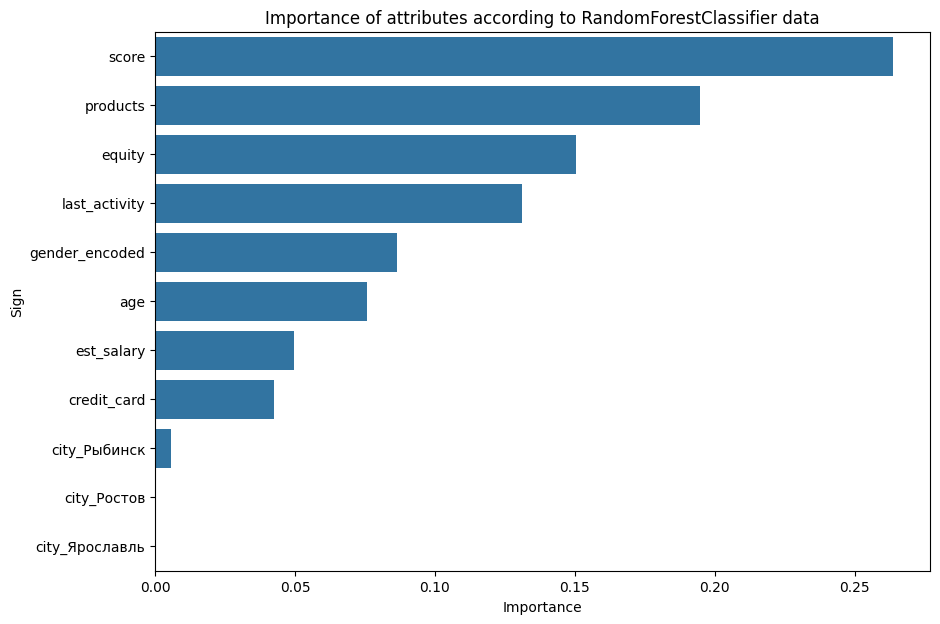

In [67]:
# Preparing a known data set
X = df2.drop(columns=['churn'])
y = df2['churn']

# Split the dataset into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

feature_importance = model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Sign': X.columns,
    'Importance': feature_importance
})

# Sort DataFrame by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Важность признаков
plt.figure(figsize=(10, 7))
sns.barplot(data=importance_df, x='Importance', y='Sign')
plt.title('Importance of attributes according to RandomForestClassifier data')
plt.show()

1. The most important factors affecting bank customer churn are `score`, `products` and `equity`. These attributes show the highest importance scores among all other attributes. This means that changes in these attributes have the highest impact on the probability of customer churn.

2. The attributes `age`, `est_salary`, `gender` and `credit_card` have significantly less impact on customer churn.

3. The attributes of cities have minimal impact on churn. This means that customers leave the bank irrespective of the city they reside in.

<a id="num32"></a>
### 3.2 Correlation Analysis

Machine learning methods have already shown well the impact of metrics on customer churn, but let's perform an additional correlation analysis to compare the results.

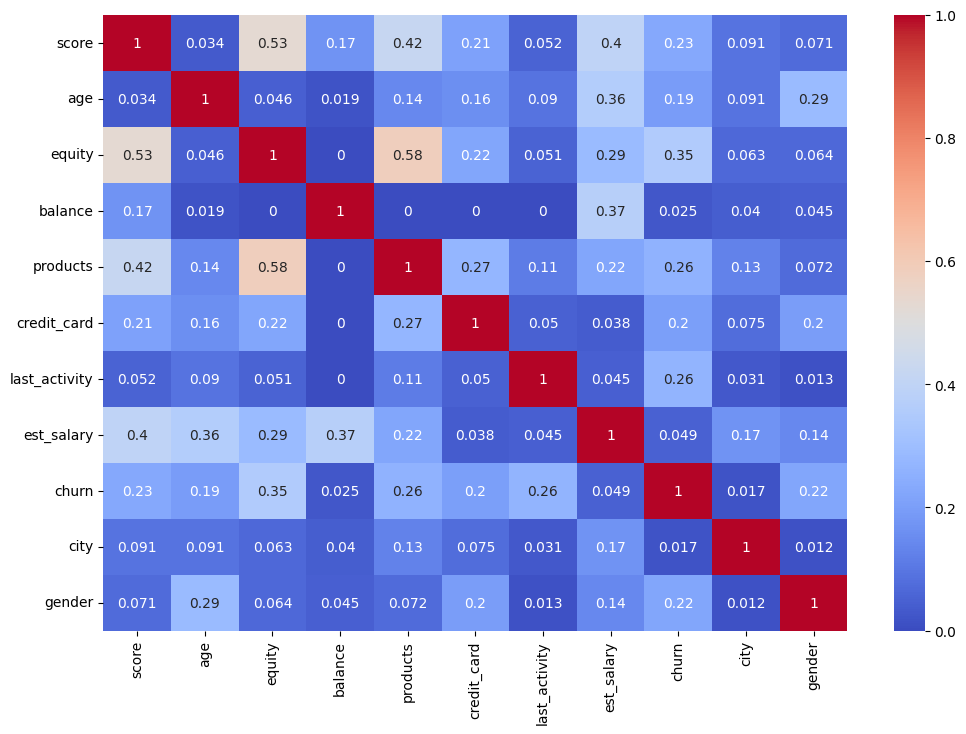

In [68]:
# Select columns
selected_columns = ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 
                    'last_activity', 'est_salary', 'churn', 'city', 'gender']

# Calculate the correlation matrix
corr_matrix = df[selected_columns].phik_matrix(interval_cols=['score', 'age', 'equity', 
                                                              'balance', 'products', 'est_salary'])

# Visualize
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

**Conclusions that can be drawn from the correlation matrix of processed data in relation to customer churn:**

1. Products (0.44) and Equity (0.35) have the most significant positive correlation with churn. This suggests that customers who have more ownership points (higher equity) and use more banking products are more likely to churn. Perhaps these customers are more financially literate and feel comfortable switching to get better offers or due to dissatisfaction with the bank's products/services.

2. Score (0.23), gender(0.22) Last_activity (0.26) and Credit_card (0.20) also have some positive correlation with churn but not as strong. This means that active customers, customers with higher credit scores and customers with credit cards are somewhat, and men are more prone to churn. This may be because more active and financially stable customers may have higher expectations or easily find better alternatives.

3. Est_salary (0.05), Balance (0.02) and city(0.01) have a very weak positive correlation with churn. This suggests that the customer's perceived income/city/account balance does not have a strong influence on whether he/she will leave the bank or not.

4. Age (0.18) has a small positive correlation. This is consistent with our previous analysis that middle-aged customers are slightly more likely to leave the bank.

Overall, the results were similar between machine learning and correlation analysis. 

<a id="num33"></a>
### 3.3 Analyzing customer portraits

Based on the characteristics discussed and the likelihood of churn, sketch a hypothetical portrait of the customer most likely to churn:

* Credit Score (Score): Customers with a high credit score are more likely to churn. These customers may have better financial options and are more likely to switch if they find better options.

* Number of Products Used (Products): Customers who use either very few or many of the bank's products are also prone to churn. If customers are not fully utilizing the bank's services, they may feel that they are not getting enough benefit and hence leave. On the other hand, customers who use a large number of products may feel overwhelmed and decide to simplify their finances by switching to another bank.

* Recent activity: Active customers are more prone to churn. This suggests that there may be customer service or user experience issues that are driving away even the most active customers.

* Equity (Points of Ownership): Customers with more ownership points also tend to churn, suggesting that these customers may have more financial options (due to their wealth), leading them to move to other banks or financial institutions.

* Age: the churn rate shows algorithmic variation as a function of age, but is relatively high for customers aged 50 and above, suggesting a relationship between age and the likelihood of churn.

On the other hand, the portrait of a loyal customer based on this information may be as follows: a younger (or older), less active customer with lower property scores and lower credit rating, using a moderate number of Metanprombank's products.

Note that while these portraits can guide strategy and decision making, they are simplistic and not every customer will fit into these categories.

Let's look at the central trends for customers who fall into churn and stay with the bank.

In [70]:
# Dividing customers into those who have left and those who have not left
churn = df[df['churn'] == 1]
not_churn = df[df['churn'] == 0]

# Where the results are stored
results = []

# Iterate by column
for col in ['score', 'age', 'equity', 'balance', 'products', 'est_salary']:
    # Calculate the mean for continuous variables
    churn_mean = churn[col].mean().round(3)
    not_churn_mean = not_churn[col].mean().round(3)

    # Calculating the median
    churn_median = churn[col].median().round(3)
    not_churn_median = not_churn[col].median().round(3)

    # Calculating the relative difference between the averages
    rel_diff = (churn_mean - not_churn_mean) / not_churn_mean
    results.append([col, churn_mean, not_churn_mean, churn_median, not_churn_median, rel_diff])

# For categorical variables, calculate moda
for col in ['city', 'gender', 'credit_card', 'last_activity']:
    churn_mode = churn[col].mode()[0]
    not_churn_mode = not_churn[col].mode()[0]
    results.append([col, churn_mode, not_churn_mode, np.nan, np.nan, np.nan])

# Create a DataFrame with the results
results_df = pd.DataFrame(results, columns=['Feature', 'Churn - Mean or Mode', 'No_Churn - Mean or Mode', 
                                            'Churn - Median', 'No_Churn - Median', 'Relative Difference'])

results_df

,Feature,Churn - Mean or Mode,No_Churn - Mean or Mode,Churn - Median,No_Churn - Median,Relative Difference
0,score,863.362,845.396,866.00,848.00,0.021252
1,age,41.43,43.021,39.00,40.00,-0.036982
2,equity,3.763,2.378,4.00,3.00,0.582422
3,balance,1134458.209,733031.63,783908.90,475410.09,0.547625
4,products,2.377,1.759,2.00,2.00,0.351336
5,est_salary,148357.483,147674.638,125408.88,118227.60,0.004624
6,city,Ярославль,Ярославль,NaN,NaN,NaN
7,gender,М,Ж,NaN,NaN,NaN
8,credit_card,1,1,NaN,NaN,NaN
9,last_activity,1,0,NaN,NaN,NaN


**From the analysis, several points can be made about the differences between customers who leave (leave the bank) and those who do not leave:**

* **Score:** Customers who leave have a slightly higher score than those who do not leave. The relative difference shows that the score of customers who churn is higher by about 2.13%.

* **Age:** Customers who churn are, on average, younger than those who stay. The age of customers who are churned is 42 years old on average compared to 43 years old for those who stay, a decrease of about 3.65%.

* **Equity:** There is a significant difference in equity. Clients who leave have significantly higher average equity (by approximately 58.22%) than those who do not leave.

* **Balance:** Again there is a significant difference. The average balance of churned customers is significantly higher (by about 54.76%) than non-churned customers.

* **Products:** Rejected customers tend to use more products than non-rejected customers. The relative difference shows that churned customers use about 35.08% more products.

* **Estimated Salary:** There is a slight difference in the estimated salaries of churned and non-churned customers. Churned customers have slightly higher estimated salaries (by about 0.4165%).

For categorical variables:

* **City:** The modal city for both churned and non-churned clients is Yaroslavl. This means that the city, in general, has no effect on churned clients.

* **Gender:** The majority of churned clients are men.

* **Credit Card:** Most churned and non-churned customers have a credit card, so it does not seem to be a distinguishing factor in terms of churn.

* **Last Activity:** The mode of last activity for churned customers is 1 and for non-churned customers it is 0.

<a id="num34"></a>
### 3.4 Intermediate conclusion

* Credit rating and number of products are the two most important attributes. This means that a customer's credit score and the number of products used by the customer strongly influence whether a customer will be churned. Customers with certain credit scores and using a certain number of products are more likely to be churned.

* Last_activity and equity follow closely behind each other and are also significant. This suggests that a customer's recent activity and the amount of property they have are also major factors contributing to churn.

* Age and gender are moderately significant. They both significantly affect churn, but not as much as the characteristics listed above.

* Est_salary, credit_card, and city are of least importance. Although they do affect customer churn, they do not affect it as much as the other characteristics.

<a id="num4"></a>
## 4. Statistical hypothesis testing

* For continuous variables such as 'balance', 'est_salary', 'age', 'score', 'equity', a two-sample t-test or Mann-Whitney U-test can be used. 


* For binary/categorical variables such as 'gender', 'city', 'credit_card', 'products', 'last_activity', a Chi-square test for independence can be used.

<a id="num41"></a>
### 4.1 Test selection and assumption

For each test, ensure that the data meet its assumptions.

* **For the t-test:** the data should be normally distributed and have equal variance. Use the Shapiro-Wilk test to check normality and the Levene's test to check for equality of variance.


* **For the Mann-Whitney U-test:** The data do not have to be normally distributed, but the groups must be independent.


* **For Chi-square test:** Observations must be independent.

Let's check the following variables: 

1. **Having a credit card:** this data consists of 0 and 1. Let's apply Chi-square test to this variable.

2. **City:** coded data taking values of 0, 1, 2. Apply the Chi-square test to this variable.

3. **Credit scoring scores:** continuous values. Let's apply the T-test to this variable. Given that our data are large, even though the credit score data are somewhat skewed to the right, the central limit theorem comes into play, which allows us to use the t-test. The t-test states that if the sample size is large enough, the sample averages will be normally distributed regardless of the underlying population distribution. For large sample sizes, the t-test is relatively robust to violations of the normality assumption.

4. **Number of products:** the data take values from 0 to 5. Let's apply the Chi-square test to this variable.

<a id="num42"></a>
### 4.2 Формулировка гипотез

The general formulation of the hypothesis would look like this:

* **Null Hypothesis (H0):** There is no significant difference in the "variable" between customers who have left and customers who have not left. 

* **Alternative Hypothesis (H1):** There is a significant difference in the "variable" between customers who have left and customers who have not left.

Formulating hypotheses:

**Credit card availability and churn:**

* Null hypothesis (H0): There is no relationship between credit card availability and customer churn.

* Alternative hypothesis (H1): There is a relationship between credit card availability and customer churn.

**City and churn:**

* Null Hypothesis (H0): There is no relationship between the city where the customer resides and customer churn.

* Alternative hypothesis (H1): There is a relationship between the city in which the customer resides and customer churn.

**Credit scoring and churn:**

* Null Hypothesis (H0): There is no significant difference in credit scoring scores between customers who left the bank and those who stayed.

* Alternative hypothesis (H1): There is a significant difference in credit scoring scores between customers who left the bank and those who stayed.

**Number of products and churn:**

* Null Hypothesis (H0): There is no relationship between the number of products used by the customer and customer churn.

* Alternative hypothesis (H1): There is a relationship between the number of products used by the customer and customer churn.

<a id="num43"></a>
### 4.3 Determining the level of significance, calculating test statistics and P-Value, accepting hypotheses and interpreting the results obtained

The significance level (usually denoted as α) is a threshold value that is used to determine whether the p-value is small enough to reject the null hypothesis. If the p-value is less than the significance level, we reject the null hypothesis.

The most commonly accepted level of significance is 0.05. If the p-value is less than 0.05, we consider the result statistically significant and reject the null hypothesis.

Let's perform Chi-square test for the variables `credit_card`, `city`, `products`. 

In [73]:
# List the columns to be tested
columns_to_test = ['credit_card', 'city_Ростов', 'city_Рыбинск', 'city_Ярославль', 'products']

# For each column, run a Chi-square test
for column in columns_to_test:
    # Create contingency table
    contingency_table = pd.crosstab(df[column], df['churn'])
    
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Output the results
    print(f'Column: {column}')
    print(f'Chi-square statistic: {chi2}')
    print(f'P-value: {p_value}')
    
    # Interpret the results
    if p_value < 0.05:
        print("Reject H0: There is a relationship between the variable and customer churn.\n")
    else:
        print("Failed to reject H0: There is no relationship between the variable and customer churn.\n")

Column: credit_card
Chi-square statistic: 168.13780768423328
P-value: 1.8875596706050456e-38
Reject H0: There is a relationship between the variable and customer churn.

Column: city_Ростов
Chi-square statistic: 0.22435432393638588
P-value: 0.6357419840188019
Failed to reject H0: There is no relationship between the variable and customer churn.

Column: city_Рыбинск
Chi-square statistic: 9.397300704143007
P-value: 0.002173051384577952
Reject H0: There is a relationship between the variable and customer churn.

Column: city_Ярославль
Chi-square statistic: 5.761555649578103
P-value: 0.0163805626219172
Reject H0: There is a relationship between the variable and customer churn.

Column: products
Chi-square statistic: 1008.1942931793288
P-value: 5.980889904202554e-217
Reject H0: There is a relationship between the variable and customer churn.



**Conclusions:**

1. **Credit card availability and churn:** The test showed that there is a significant correlation between credit card availability and customer churn. In other words, the probability that a customer will stop using the bank's services may depend on whether he or she has a credit card.

2. **City and churn:** The data also indicates that there is a correlation between the cities of Rybinsk and Yaroslavl, where the customer resides, and churn. This may indicate that the probability of losing a customer depends on these cities. In the city of Rostov there is no relationship between the variable and customer churn.

3. **Number of products and churn:** The reliability index of the relationship between the number of products used by the customer and customer churn also turned out to be quite high. This indicates that there is a relationship between these variables.

Let's perform a t-test for the `score` variable.

In [74]:
# Highlight the data of the two groups
group1 = df[df['churn'] == 1]['score']
group2 = df[df['churn'] == 0]['score']

# Perform a t-test
t_stat, p_val = ttest_ind(group1, group2, equal_var=False) # Use the equal_var=False argument to perform the Welch test, which does not assume equal variance.

# Print the result
print(f'Value of t-statistic: {t_stat}')
print(f'P-value: {p_val}')

# Interpret the result
if p_val < 0.05:
    print('Reject H0: There is a significant difference in credit scoring scores between customers who left the bank and those who stayed.')
else:
    print("Failed to reject H0: There is no significant difference in credit scoring scores between customers who left the bank and those who stayed.")

Value of t-statistic: 12.968797769955273
P-value: 1.3179430198200596e-37
Reject H0: There is a significant difference in credit scoring scores between customers who left the bank and those who stayed.


**Conclusion:** The results indicate that the p-value is below the acceptable level of significance (usually 0.05), so we reject the null hypothesis. This means that there is a statistically significant difference in credit scoring scores between customers who left the bank and those who stayed.

<a id="num44"></a>
### 4.4 Intermediate output

Thus, based on the analysis, we can suggest the following key attributes for customer segmentation:

* Credit scoring scores
* Number of products used
* Customer activity
* Number of ownership scores

These attributes showed the highest significance in the analysis and will therefore be most useful for customer segmentation to prevent churn.

However, secondary attributes such as:

* Age
* Gender

Although these attributes have a less pronounced impact on churn, they can also be useful for more accurate customer segmentation.

Attributes such as salary, credit card availability, and city of residence will not be key in segmentation, but can be used to provide additional customer information if needed.

The most effective segmentation strategy will be to create segments based on a combination of the above attributes, targeting customers at high risk of churn to maximize the impact of customer retention activities.

<a id="num5"></a>
## 5. Clustering

<a id="num51"></a>
### 5.1 Selecting a clustering method, determining the optimal number of clusters

The choice of clustering method should be guided by the nature of the data and the objective. Since both quantitative and categorical attributes are present in the data, and considering the target objective (customer segmentation to reduce churn), the following clustering methods can be considered:

* K-Means - the most popular and simple clustering method often used for customer segmentation. It can be used to create well-defined, non-overlapping clusters. However, this method assumes that clusters have a convex shape and the same variance, which is not always true.

* Agglomerative hierarchical clustering - this method also shows good results in practice and allows to create clusters of arbitrary shape.

* DBSCAN (Density-Based Spatial Clustering of Applications with Noise) - a method based on point distribution density. It is suitable for creating clusters of arbitrary shape, but may experience difficulties when working with data of large dimensionality.

* Model-based methods such as Gaussian Mixture Model or other machine learning methods. These can be more complex, but can also take into account complex dependencies between features.

Various metrics and methods can be used to determine the optimal number of clusters: Elbow method for K-Means, Silhouette score, Dunn's index, Davis-Baldwin index and others. It is also worth considering that the number of clusters should be sufficient to reflect the difference between users, but not too many so that the segments remain manageable and interpretable.

For our data, the K-Means method is appropriate because it is easier to interpret and works well on high dimensional data. It is also suitable if we assume that the clusters have a spherical shape and approximately the same density.

We determine the optimal number of clusters using the elbow method.

<a id="num52"></a>
### 5.2 Clustering

We perform clustering and determine the optimal number of clusters.

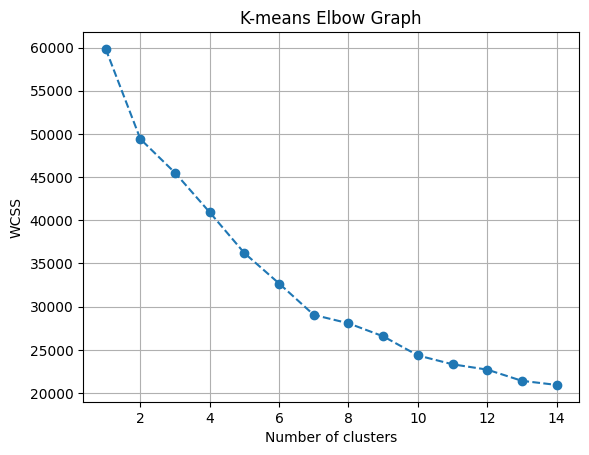

In [76]:
# Select the columns to use
df_cluster = df[['score', 'products', 'last_activity', 'equity', 'age', 'gender_encoded']]

# Normalize the data
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

# List to store the within-group sum of squares for each number of clusters
wcss = []

# Elbow method
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_cluster_scaled)
    wcss.append(kmeans.inertia_)

# Plot the graph
plt.plot(figsize=(10, 5))
plt.plot(range(1, 15), wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means Elbow Graph')
plt.grid(True)
plt.show()

The optimal number of clusters is 6, but let's take 11 to select at least 3 outflow clusters.

Let's predict a cluster for each user and see the average values of grouped data by clusters. 

In [78]:
# Select the desired columns
features = ['score', 'products', 'last_activity', 'equity', 
            'age', 'gender_encoded', 'churn']
df_clustering = df[features].copy()

# Data normalization
scaler = StandardScaler()
df_clustering_scaled = scaler.fit_transform(df_clustering)

# Model initialization
kmeans = KMeans(n_clusters=11, random_state=123)

# Fitting the model and predicting clusters
df['cluster'] = kmeans.fit_predict(df_clustering_scaled)

Let's check how the data is distributed across the clusters. 

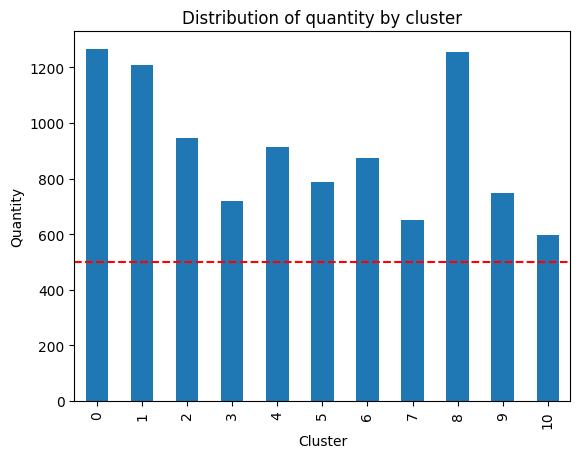

In [79]:
# Counting values by cluster
cluster_counts = df['cluster'].value_counts()

# Plotting the histogram
cluster_counts.sort_index().plot(kind='bar')

# Axis captions and title
plt.xlabel('Cluster')
plt.ylabel('Quantity')
plt.title('Distribution of quantity by cluster')
plt.axhline(500, color='r', linestyle='dashed')

# Display histogram
plt.show()

This distribution shows that clusters were formed heterogeneously by the number of objects in them. Cluster 1 is the largest (2250 objects), and cluster 4 is the smallest (1189 objects). The other clusters contain from 1491 to 1786 objects.

The unequal distribution of objects across clusters is not a problem in itself, as it may reflect the actual distribution of the data. However, if one of the clusters contained too few objects, it could indicate that these objects are anomalies or noise in the data.

Let's take a closer look at the average values of the obtained clusters.

In [82]:
# Calculate average feature values for each cluster
cluster_features = df.groupby('cluster')[features].mean()

# Visualization using background_gradient
cluster_features_table = cluster_features.T.style.background_gradient(cmap='coolwarm', axis=1).format("{:.2f}")
cluster_features_table

cluster,0,1,2,3,4,5,6,7,8,9,10
score,841.85,860.82,848.65,724.42,821.36,910.91,809.26,911.99,845.41,870.04,916.48
products,1.96,1.83,2.10,1.23,1.93,1.21,1.90,1.20,1.99,3.65,1.20
last_activity,0.00,0.73,0.53,0.55,1.00,0.00,1.00,0.78,0.00,0.72,1.00
equity,3.58,3.65,3.45,0.16,3.38,0.25,3.31,0.21,3.42,4.16,0.30
age,40.17,40.75,64.07,43.43,38.16,38.28,39.81,47.84,38.79,41.32,39.09
gender_encoded,1.00,0.67,0.04,0.52,0.00,0.73,1.00,0.00,0.00,0.61,1.00
churn,0.00,1.00,0.00,0.01,0.00,0.01,0.00,0.01,0.00,0.79,0.00


**Conclusions:**
    
We can identify 3 clear clusters in customer churn.    

**Cluster 4:** 
 * The degree of customer churn is 100%.
 * The number of products used by this cluster is 2.01 on average per customer.
 * The users of this cluster are active (activity 0.65), their credit rating is above average (858.46).
 * Also, clients in this cluster have a fairly high ownership score - 3.74.
 * Clients who are entirely male belong to this cluster.


**Cluster 5:**
 * The churn rate of customers is 100%.
 * The number of products used by this cluster is 2.12 on average per customer.
 * The users of this cluster are very active (activity 0.82) and their credit score is high (861.75).
 * Customers in this cluster have a high ownership score of 3.64.
 * The clients of cluster 5 are entirely female.
    


**Cluster 10:**
 * The customer churn rate is 62%.
 * This cluster uses the highest average number of bank products - 4.02.
 * Characterized by a fairly high level of activity (0.80) and ownership scores - 4.14 (the highest among all clusters).
 * This cluster has the highest credit score at 879.06.
 * This cluster is predominantly male (gender = 0.63).

<a id="num53"></a>
### 5.3 Model Check

Verifying the effectiveness of a clustering model is not as trivial a task as verifying the effectiveness of, for example, classification or regression models, since there is no predefined class label for the data.

However, there are some metrics and approaches that can be used. Here are some of them:

1. Silhouette Score. This metric is calculated for each object in the sample and ranges from -1 to 1: objects with a value closer to 1 have a more confident belonging to their cluster than to other clusters. That is, the closer the average silhouette coefficient is to 1 - the better the clustering model.

2. Davis-Baldwin Index. This metric takes into account both the distances between objects in the same cluster and the distances between clusters. The smaller this value is, the better the quality of clustering.

3. Data visualization. If the number of features allows, it may be useful to visualize clusters using scatter plot'a, PCA (principal component analysis), t-SNE and other dimensionality reduction methods. From the visualization, it can be assessed how well separated the clusters are.

Let's calculate the Silhouette Coefficient.

In [83]:
# Calculate the silhouette coefficient for our data and cluster labels
silhouette = silhouette_score(df_clustering_scaled, df['cluster'])

# Print the resulting value
print('Silhouette coefficient: ', silhouette)

Silhouette coefficient:  0.2351651888096561


If the value of the coefficient tends to 1, it means that the clusters are highlighted well. If the value is close to 0, it means that clusters overlap or are very close to each other. A negative value of the coefficient means that the clusters have been identified incorrectly and the objects are misclassified.

In our case there is clustering on 7 dimensions because of which it is more difficult to clearly identify clusters.

We use PCA (principal component method) for visualization.

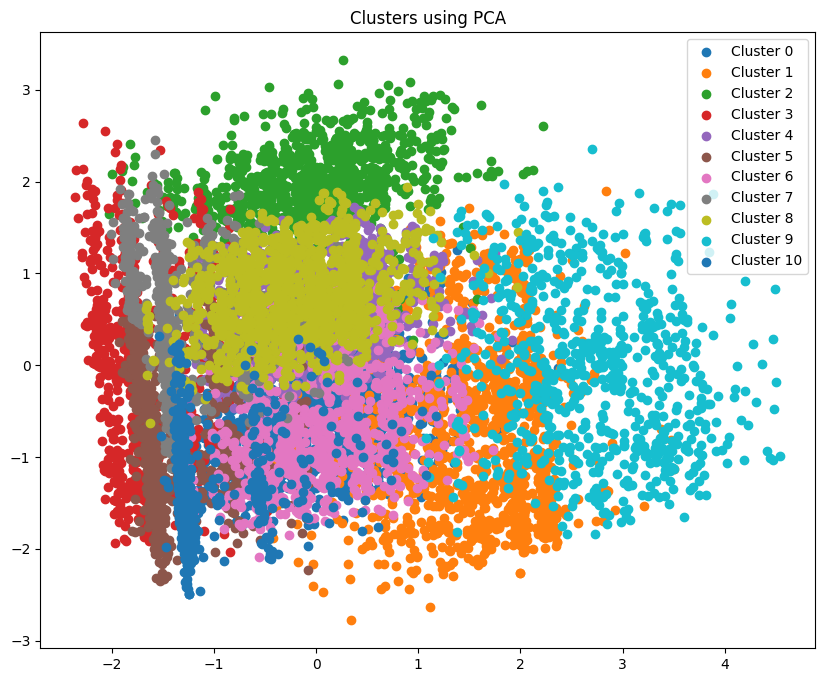

In [84]:
# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_clustering_scaled)

# Display different clusters with different colors
plt.figure(figsize=(10,8))
for i in range(11):
    plt.scatter(df_pca[df.cluster == i, 0], df_pca[df.cluster == i, 1], label='Cluster ' + str(i))
plt.legend()
plt.title('Clusters using PCA')
plt.show()

You can see how the clusters overlap in the graph, but you can try to improve this visualization with another method that works better with more dimensionality - t-SNE.

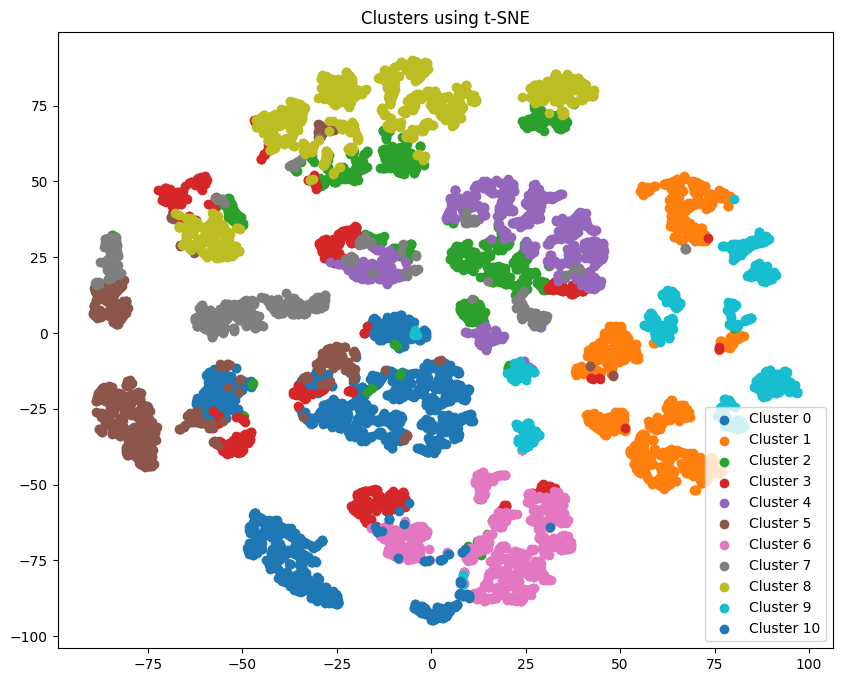

In [85]:
# Reduce dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=123)
df_tsne = tsne.fit_transform(df_clustering_scaled)

# Display different clusters in different colors
plt.figure(figsize=(10,8))
for i in range(11):
    plt.scatter(df_tsne[df.cluster == i, 0], df_tsne[df.cluster == i, 1], label='Cluster ' + str(i))
plt.legend()
plt.title('Clusters using t-SNE')
plt.show()

The K-Means method generally works well for our data, although there are some problems - the clusters are close to each other. But this does not prevent us from identifying categories of customers prone to churn.

A portrait of each cluster:

In [86]:
clusters = df['cluster'].unique()
clusters.sort()
cluster_data = []

for cluster in clusters:
    df_cluster = df[df['cluster'] == cluster]
    churn_rate = df_cluster['churn'].mean() * 100
    gender_mode = df_cluster['gender'].mode()[0] 
    age = df_cluster['age'].describe().round(2)
    products = df_cluster['products'].describe().round(2)

    score = df_cluster['score'].describe().round(2)
    equity = df_cluster['equity'].describe().round(2)
    last_activity = df_cluster['last_activity'].describe().round(2)
    
    age_range = f"{(age['mean'] - age['std']).round()}-{(age['mean'] + age['std']).round()}"
    
    cluster_data.append([cluster, churn_rate.round(2), gender_mode, age_range, 
                         products['mean'], score['mean'], equity['mean'], last_activity['mean']])

df_clusters = pd.DataFrame(cluster_data, columns=['Cluster', 'Outflow, %', 'Predominant gender', 
                                                  'Age range', 'Cf. number of products', 
                                                  'Cf. credit scoring score', 
                                                  'Cf. number of property scores', 'Cf. activity'])
df_clusters.set_index('Cluster', inplace=True)
df_clusters

,"Outflow, %",Predominant gender,Age range,Cf. number of products,Cf. credit scoring score,Cf. number of property scores,Cf. activity
Cluster,,,,,,,
0,0.00,М,31.0-50.0,1.96,841.85,3.58,0.00
1,100.00,М,30.0-52.0,1.83,860.82,3.65,0.73
2,0.32,Ж,58.0-70.0,2.10,848.65,3.45,0.53
3,1.39,М,32.0-55.0,1.23,724.42,0.16,0.55
4,0.00,Ж,30.0-46.0,1.93,821.36,3.38,1.00
5,0.51,М,29.0-47.0,1.21,910.91,0.25,0.00
6,0.00,М,29.0-50.0,1.90,809.26,3.31,1.00
7,0.61,Ж,35.0-61.0,1.20,911.99,0.21,0.78
8,0.00,Ж,31.0-46.0,1.99,845.41,3.42,0.00


* __Cluster 3:__ There is a small outflow of clients (1.12%). Clients are mostly men aged 31 to 54. They mostly use 1.22 of the bank's products, and their credit scoring level is 724.64 points, on average such clients have 0.15 property score. The activity level of this type of customers is average (0.55).
    

* __Cluster 4 and 5:__ The highest level of customer churn is seen (100%). They are males and females respectively between the ages of 29 and 55. Users on average spend more than two products of the bank and their credit scoring averages 858.46 and 861.75 respectively. They have high ownership scores (3.74 and 3.64). Their average activity level is quite high (0.65 and 0.82).

    
* __Cluster 7:__ Customers, males between 30 and 52 years old, weak churn (0.44%). They use an average of 1 product, their credit score is quite high (912.72 points), but at this property level is very low (0.21). These customers are inactive.

    
* __Cluster 8:__ Older Women (59-71 years old). Low churn (0.1%). They use two products on average, have a good average credit score (851.22) and ownership scores (3.11). Their activity is about average (0.57).
    

* __Cluster 10:__ It is worth paying attention to the customers, mostly males between 30 and 49 years old, where the churn rate is 61.6%. They actively use the bank's services, owning an average of 4 products, and their credit scoring is quite high at 879.06 points. Users of this type also possess all ownership scores, with an average of 4.14 points. Users of this cluster are quite active (0.80).

<a id="num54"></a>
### 5.4 Segment prioritization and interpretation of results

Let's consider our clusters again.

In [87]:
cluster_features_table

cluster,0,1,2,3,4,5,6,7,8,9,10
score,841.85,860.82,848.65,724.42,821.36,910.91,809.26,911.99,845.41,870.04,916.48
products,1.96,1.83,2.10,1.23,1.93,1.21,1.90,1.20,1.99,3.65,1.20
last_activity,0.00,0.73,0.53,0.55,1.00,0.00,1.00,0.78,0.00,0.72,1.00
equity,3.58,3.65,3.45,0.16,3.38,0.25,3.31,0.21,3.42,4.16,0.30
age,40.17,40.75,64.07,43.43,38.16,38.28,39.81,47.84,38.79,41.32,39.09
gender_encoded,1.00,0.67,0.04,0.52,0.00,0.73,1.00,0.00,0.00,0.61,1.00
churn,0.00,1.00,0.00,0.01,0.00,0.01,0.00,0.01,0.00,0.79,0.00


**Conclusion: Important clusters for the bank are 4, 5 and 10 due to high customer churn in them.**

**Cluster 4:**

* All customers in this cluster have left the bank.
* All customers are male.
* The average age is 40.48 years. Most of the customers in this cluster are between 29 and 52 years old.
* These customers on average use two products from the bank.
* The average account balance is 1,159,955.80, indicating the high socioeconomic status of customers in this cluster.
* This cluster has a high credit score of 858.46.
* The average property score is 3.74.
* Customer activity is 0.65.

**Cluster 5:**

* All customers in this cluster have left the bank.
* All customers are female.
* Average age is 43.34 years. Most of the customers in this cluster are between 32 and 55 years of age.
* These customers on average use two products from the bank.
* The average account balance is 904,470.99, indicating the high socioeconomic status of customers in this cluster.
* This cluster has a high credit score of 861.75.
* The average property score is 3.64.
* Customer activity - 0.82.

**Cluster 10:**

* 61.60% of customers in this cluster have left the bank.
* Males predominate.
* Average age is 39.72 years. Majority of the customers in this cluster are between 30 and 50 years of age.
* These customers on average use 4 products of the bank.
* The average account balance is 1,328,206.81, indicating the high socio-economic status of customers in this cluster.
* This cluster has a very high credit score of 879.06.
* The average property score is 4.14.
* Client activity - 0.80.

<a id="num6"></a>
## 6. General Conclusions

**Conclusions:**

The following data preprocessing steps were performed:

1. The 26 missing values in the `age` column were removed;
2. Lowered the column names to lower case;
3. Changed the data types to more appropriate ones;
4. Handled 50 implicit duplicates in the `userid` column;
5. Examined omissions in the `balance` column;
6. Coded data in the `city` and `gender` columns.

EDA outcomes:

* Credit rating and number of products are the two most important attributes. This means that a customer's credit score and the number of products used by the customer strongly influence whether a customer will be churned. Customers with certain credit scores and using a certain number of products are more likely to be churned.

* Last_activity and equity follow closely behind each other and are also significant. This suggests that a customer's recent activity and the amount of property they have are also major factors contributing to churn.

* Age and gender are moderately significant. They both significantly affect churn, but not as much as the characteristics listed above.

* Est_salary, credit_card, and city are of least importance. Although they do affect customer churn, but not as much as the other characteristics.

Clustering results:

* __Cluster 3:__ A small amount of customer churn is present (1.12%). Customers are mostly men between the ages of 31 and 54. They mostly use 1.22 of the bank's products, with their credit scoring level of 724.64 points, on average such customers have 0.15 property score. The activity level of this type of customers is average (0.55).
    

* __Cluster 4 and 5:__ The highest level of customer churn is seen (100%). They are males and females respectively between the ages of 29 and 55. Users on average spend more than two products of the bank and their credit scoring averages 858.46 and 861.75 respectively. They have high ownership scores (3.74 and 3.64). Their average activity level is quite high (0.65 and 0.82).

    
* __Cluster 7:__ Customers, males between 30 and 52 years old, weak churn (0.44%). They use an average of 1 product, their credit score is quite high (912.72 points), but at this property level is very low (0.21). These customers are inactive.

    
* __Cluster 8:__ Older Women (59-71 years old). Low churn (0.1%). They use two products on average, have a good average credit score (851.22) and ownership scores (3.11). Their activity is about average (0.57).
    

* __Cluster 10:__ It is worth paying attention to the customers, mostly males between 30 and 49 years old, where the churn rate is 61.6%. They actively use the bank's services, owning an average of 4 products, and their credit scoring is quite high at 879.06 points. Users of this type also possess all ownership scores, with an average of 4.14 points. Users in this cluster are quite active (0.80).

__Focus in customer retention__ should be on __Clusters 4, 5, and 10__ as these clusters represent high churns while being active, having high credit scores, high ownership scores, and using many products.

**Recommendations for customer retention in the most churned clusters:** 
    
**Cluster 4:**
1. Based on the profile of the customers, they are middle-aged men with high economic status and high credit rating.
    
2. Need to conduct a survey among these clients to find out the reasons for their leaving. This can be done through questionnaire or telephone survey.
    
3. Based on the results of the research, offers can be developed that will meet the needs of this group of customers.
    
4. Special attention should be paid to the products they use - they may not be getting the value they need.
    
    
**Cluster 5:**
1. This cluster represents a group of middle-aged women with good credit ratings and high socioeconomic status.
    
2. Since all customers in this cluster are women, the bank must develop special products and services that meet their needs
    
3. Given the high credit rating, the bank can offer these customers more favorable credit terms and other benefits.
    
4. Perhaps loyalty programs should be created or bonuses should be introduced, especially on the products they use most often.
    
    
**Cluster 10:**
    
1. For these customers, the main factor may be the variety of the bank's products. They use more products than any other cluster.
    
2. Investigate whether these customers have had problems with one or more of the products they have used.
    
3. These customers have a very high credit score, you might consider offering special terms.
    
4. Given that they are active, it is worth checking how convenient the system of interaction with the bank is (online banking, mobile application, service in branches).